# **0. Importación de <ins>librerías</ins> y <ins>carga de archivos</ins>**

In [1]:
## IMPORTACIÓN DE LIBRERÍAS

import pandas as pd # Pandas
import matplotlib.pyplot as plt # Matplorlib
import matplotlib.colors as mcolors # Matplorlib
import matplotlib.dates as mdates

#from dateutil.relativedelta import relativedelta # Dates
#import seaborn as sns #Seaborn
import numpy as np #Numpy
from matplotlib.colors import LinearSegmentedColormap #Paleta de colores
import pycaret

#from pycaret.regression import *
from prophet import Prophet
from pycaret.regression import save_model
from pycaret.regression import load_model

# Desactivamos Warnings

import warnings
warnings.filterwarnings('ignore')
from pycaret.regression import setup, compare_models
from sklearn.model_selection import TimeSeriesSplit
#from pycaret.clustering import *
from pycaret.regression import setup
import matplotlib.pyplot as plt

import seaborn as sns

from pycaret.regression import ensemble_model
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os

In [2]:
"""

## IMPORTACIÓN DE LIBRERÍAS

# Instalar pycaret
# !pip install pycaret[full]

# Importar librerías necesarias de PyCaret
#from pycaret.regression import setup, compare_models, finalize_model, predict_model, tune_model, blend_models # Pycaret

import pandas as pd # Pandas
import matplotlib.pyplot as plt # Matplotlib
import matplotlib.colors as mcolors # Matplotlib
from dateutil.relativedelta import relativedelta
import seaborn as sns # Seaborn
import numpy as np # Numpy
from matplotlib.colors import LinearSegmentedColormap # Matplotlib
from sklearn.preprocessing import StandardScaler # SKLearn
from sklearn.cluster import KMeans # SKLearn
import os # Os

# Desactivar warnings
import warnings
warnings.filterwarnings('ignore')

# Conexión con Google Colab
from google.colab import drive
drive.mount('/content/drive')

SyntaxError: incomplete input (2253417201.py, line 1)

In [3]:
# Cargar los DataFrame
df_Promos = pd.read_excel('ProdEnPromo-UM.xls', engine='xlrd')
df_Productos = pd.read_excel('Producto-UM.xls', engine='xlrd')
df_Ventas = pd.read_excel('VentasPR.xlsx', engine='openpyxl')

# Verificar que los dataframes se hayan cargado correctamente
print("Primeras filas de df_Promos:")
print(df_Promos.head())

print("\nPrimeras filas de df_Productos:")
print(df_Productos.head())

print("\nPrimeras filas de df_Ventas:")
print(df_Ventas.head())


Primeras filas de df_Promos:
   PRDCODEXT PROMDEFFECDES PROMDEFFECHAS
0     560226    2023-02-13    2023-02-26
1     560227    2023-02-13    2023-02-26
2     561875    2023-02-13    2023-02-26
3     561895    2023-02-13    2023-02-26
4     561899    2023-02-13    2023-02-26

Primeras filas de df_Productos:
      Cod  Status Hoy   Prov  Cat   Tipo Prov
0  561699           5  68952   216          1
1  561634           5  68952   216          1
2  561694           5  68952   216          1
3  561826           5  68952   216          1
4  561891           5  68952   216          1

Primeras filas de df_Ventas:
   LOCCOD    MOVFEC  PRDCODEXT  ACPRCANTVEND ACPRIMPVEN
0    5201  2/5/2021     600790             7       1393
1    5201  2/5/2021     600793             2        390
2    5201  2/5/2021     600794             7       2023
3    5201  2/5/2021     605089             1        399
4    5201  2/5/2021     605097             1        565


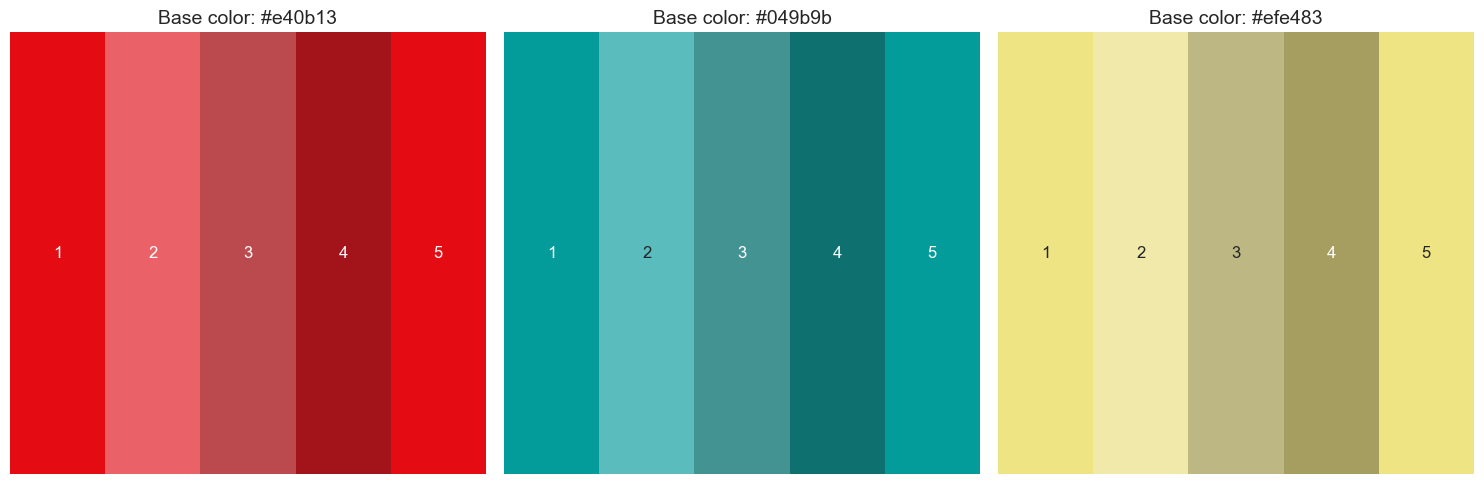

In [4]:
## DEFINICIÓN DE PALETA DE COLORES


# Colores base
colores_base = ['#e40b13', '#049b9b', '#efe483']

# Función para generar colores más claros y más oscuros
def generar_paleta(color_hex, num_colores=5):
    # Convertir el color HEX a RGB
    color_rgb = mcolors.hex2color(color_hex)
    # Generar colores más claros y más oscuros
    paleta = sns.light_palette(color_rgb, n_colors=(num_colores // 2) + 1, reverse=True)[:-1] + \
             sns.dark_palette(color_rgb, n_colors=(num_colores // 2) + 1)[1:]
    return paleta

# Generar las paletas
paletas = [generar_paleta(color) for color in colores_base]

# Crear una función para graficar con degradado
def plot_bar_with_gradient(ax, data, labels, palette, title, ylabel, value_format):
    norm = plt.Normalize(data.min(), data.max())
    colors = [palette[int(norm(value) * (len(palette) - 1))] for value in data]
    bars = ax.bar(labels, data, color=colors)
    for bar, value in zip(bars, data):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), value_format.format(value).replace(',', '.'),
                ha='center', va='bottom', fontsize=10)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mes-Año')
    ax.set_xticklabels(labels, rotation=90)

# Visualizar las paletas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax, paleta, color_base in zip(axs, paletas, colores_base):
    sns.heatmap(np.arange(1, 6).reshape(1, 5), ax=ax, cmap=LinearSegmentedColormap.from_list("", paleta),
                cbar=False, annot=True, xticklabels=False, yticklabels=False)
    ax.set_title(f'Base color: {color_base}', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

---

# **1. Exploración inicial de las bases**

In [5]:
## BASE PROMO

df_Promos

# PRDCODEXT: Código que identifica al producto
# PROMEFFECDES: Fecha desde cunado entró en promoción
# PROMDEFFECHAS: Fecha hasta cuando duró la promoción

# Renombramos columnas
df_Promos.rename(columns={
    'PRDCODEXT': 'ID_producto',
    'PROMDEFFECDES': 'Inicio_promo',
    'PROMDEFFECHAS': 'Fin_promo'
}, inplace=True)

# Convertimos las columnas de fechas en formato "datetime64"
df_Promos['Inicio_promo'] = pd.to_datetime(df_Promos['Inicio_promo'], format='%d/%m/%Y')
df_Promos['Fin_promo'] = pd.to_datetime(df_Promos['Fin_promo'], format='%d/%m/%Y')

# Convertimos "ID_producto" formato String -> Esta variable corresponde a código, por lo cual no deben ser interpretada como variable numérica
df_Promos['ID_producto'] = df_Promos['ID_producto'].astype(float).astype(int).astype(str)

# Creamos la variable "Duracion_promo"
df_Promos['Duracion_promo'] = (df_Promos['Fin_promo'] - df_Promos['Inicio_promo']).dt.days

# Proyectamos Dataframe
df_Promos.head(10)

,ID_producto,Inicio_promo,Fin_promo,Duracion_promo
0,560226,2023-02-13,2023-02-26,13
1,560227,2023-02-13,2023-02-26,13
2,561875,2023-02-13,2023-02-26,13
3,561895,2023-02-13,2023-02-26,13
4,561899,2023-02-13,2023-02-26,13
5,600936,2021-05-17,2021-05-30,13
6,607016,2021-05-17,2021-05-30,13
7,607064,2021-05-17,2021-05-30,13
8,607065,2021-05-17,2021-05-30,13
9,607066,2021-05-17,2021-05-30,13


In [6]:
## BASE PRODUCTO

df_Productos

# Cod: Código que identifica el producto
# Status Hoy: Situación del producto: 1- Activo, 2- Congelado, 3- Congelado para la compra
# Prov: Código que identifica al proveedor
# Cat: 216: Vinos finos, 217 Espumantes
# Tipo Prov: Tipo de proveedor; 1- Provedor Externo, 3- Logistico

# Renombramos columnas
df_Productos.rename(columns={
    'Cod': 'ID_producto',
    'Status Hoy': 'Status',
    'Prov': 'ID_proveedor',
    'Cat ': 'Categoria',
    'Tipo Prov': 'Clasif_proveedor'
}, inplace=True)

# Convertimos "ID_producto", "Status", "ID_proveedor", "Categoria" y "Clasif_proveedor" a formato String -> Estas variables corresponden a códigos, por lo cual no deben ser interpretadas como variables numéricas
df_Productos['ID_producto'] = df_Productos['ID_producto'].astype(float).astype(int).astype(str)
df_Productos['Status'] = df_Productos['Status'].astype(float).astype(int).astype(str)
df_Productos['ID_proveedor'] = df_Productos['ID_proveedor'].astype(float).astype(int).astype(str)
df_Productos['Categoria'] = df_Productos['Categoria'].astype(float).astype(int).astype(str)
df_Productos['Clasif_proveedor'] = df_Productos['Clasif_proveedor'].astype(float).astype(int).astype(str)

# Proyectamos Dataframe
df_Productos.head(10)

,ID_producto,Status,ID_proveedor,Categoria,Clasif_proveedor
0,561699,5,68952,216,1
1,561634,5,68952,216,1
2,561694,5,68952,216,1
3,561826,5,68952,216,1
4,561891,5,68952,216,1
5,561900,5,68952,216,1
6,604124,5,10067,216,1
7,604710,1,10214,216,1
8,560912,5,10214,216,1
9,601047,5,10214,216,1


In [7]:
## BASE VENTAS

df_Ventas

# LOCCOD: Número de Local
# MOVFEC: Fecha de Venta
# PRDCODEXT: Código de producto vendido
# ACPRCANTVEND: Cantidades vendidas
# ACPRIMPVEN: Facturación

# Renombramos columnas
df_Ventas.rename(columns={
    'LOCCOD': 'ID_tienda',
    'MOVFEC': 'Fecha_venta',
    'PRDCODEXT': 'ID_producto',
    'ACPRCANTVEND': 'Cant_vendidas',
    'ACPRIMPVEN': 'Facturacion'
}, inplace=True)

# Convertimos las columnas de fechas en formato "datetime64"
df_Ventas['Fecha_venta'] = pd.to_datetime(df_Ventas['Fecha_venta'], format='%d/%m/%Y')

# Convertimos "ID_producto", "ID_tienda" a formato String -> Estas variables corresponden a códigos, por lo cual no deben ser interpretadas como variables numéricas
df_Ventas['ID_producto'] = df_Ventas['ID_producto'].astype(float).astype(int).astype(str)
df_Ventas['ID_tienda'] = df_Ventas['ID_tienda'].astype(float).astype(int).astype(str)

# Convertimos las columnas "Facturacion" y "Cant_vendidas" a cadena para poder reemplazar comas por puntos
df_Ventas['Facturacion'] = df_Ventas['Facturacion'].astype(str).str.replace(',', '.').astype(float)
df_Ventas['Cant_vendidas'] = df_Ventas['Cant_vendidas'].astype(str).str.replace(',', '.').astype(int)

# Crear la variable "Precio_unidad"
df_Ventas['Precio_unidad'] = df_Ventas['Facturacion'] / df_Ventas['Cant_vendidas']


# Diccionario para denominar los días de semana en español
dias_semana = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

# Creamos la variable "Dia_sem" en español
df_Ventas['Dia_sem'] = df_Ventas['Fecha_venta'].dt.day_name().map(dias_semana)

# Proyectamos Dataframe
df_Ventas.head(10)

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem
0,5201,2021-05-02,600790,7,1393.0,199.0,Domingo
1,5201,2021-05-02,600793,2,390.0,195.0,Domingo
2,5201,2021-05-02,600794,7,2023.0,289.0,Domingo
3,5201,2021-05-02,605089,1,399.0,399.0,Domingo
4,5201,2021-05-02,605097,1,565.0,565.0,Domingo
5,5201,2021-05-02,605548,1,305.0,305.0,Domingo
6,5201,2021-05-02,607019,1,429.0,429.0,Domingo
7,5201,2021-05-02,607064,2,670.0,335.0,Domingo
8,5201,2021-05-02,607065,1,335.0,335.0,Domingo
9,5201,2021-05-02,607188,1,329.0,329.0,Domingo


---

# **2. <ins>Unificación</ins> y <ins>simplificación</ins> de las bases de datos**

In [8]:
# Realizar el merge entre df_Productos y df_Ventas
df_merged = pd.merge(df_Ventas, df_Productos, on='ID_producto', how='left')

# Proyectamos el dataframe resultante
df_merged.head(10)

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor
0,5201,2021-05-02,600790,7,1393.0,199.0,Domingo,1,31064,216,1
1,5201,2021-05-02,600793,2,390.0,195.0,Domingo,1,31064,216,1
2,5201,2021-05-02,600794,7,2023.0,289.0,Domingo,1,31064,216,1
3,5201,2021-05-02,605089,1,399.0,399.0,Domingo,1,22010,216,1
4,5201,2021-05-02,605097,1,565.0,565.0,Domingo,5,10145,216,1
5,5201,2021-05-02,605548,1,305.0,305.0,Domingo,1,31062,216,1
6,5201,2021-05-02,607019,1,429.0,429.0,Domingo,1,10145,216,1
7,5201,2021-05-02,607064,2,670.0,335.0,Domingo,1,10214,216,1
8,5201,2021-05-02,607065,1,335.0,335.0,Domingo,1,10214,216,1
9,5201,2021-05-02,607188,1,329.0,329.0,Domingo,5,10214,216,1


In [9]:
## Corroboramos que no existan duplicados
df_merged.duplicated().sum()

0

In [10]:
## Eliminamos del Dataframe las DEVOLUCIONES DE PRODUCTOS

# Contar las veces que "Cant_vendidas" es inferior a 0
cant_vendidas_menor_0 = df_merged[df_merged['Cant_vendidas'] < 0].shape[0]
print(f"Número de veces que 'Cant_vendidas' es menor a 0: {cant_vendidas_menor_0}")

# Contar las veces que "Cant_vendidas" es igual a 0
cant_vendidas_igual_0 = df_merged[df_merged['Cant_vendidas'] == 0].shape[0]
print(f"Número de veces que 'Cant_vendidas' es igual a 0: {cant_vendidas_igual_0}")

# Contar las veces que "Cant_vendidas" es nulo
cant_vendidas_nulo = df_merged['Cant_vendidas'].isnull().sum()
print(f"Número de veces que 'Cant_vendidas' es nulo: {cant_vendidas_nulo}")

# Eliminar filas donde "Cant_vendidas" es menor o igual a 0 o es nulo
df_merged = df_merged[df_merged['Cant_vendidas'] > 0].dropna(subset=['Cant_vendidas'])

Número de veces que 'Cant_vendidas' es menor a 0: 132
Número de veces que 'Cant_vendidas' es igual a 0: 997
Número de veces que 'Cant_vendidas' es nulo: 0


In [11]:
## Detectamos que variables cuentan con valores faltantes

df_merged.isnull().sum()

ID_tienda             0
Fecha_venta           0
ID_producto           0
Cant_vendidas         0
Facturacion           0
Precio_unidad         0
Dia_sem               0
Status              181
ID_proveedor        181
Categoria           181
Clasif_proveedor    181
dtype: int64

In [12]:
## Eliminamos aquellas ventas donde se presenten valores faltantes para alguna de las variables. Esto se realiza en pos de ejecutar correctamente los modelos de machine learning a posteriori

# Contar el número de filas con algún valor faltante antes de eliminar
valores_faltantes = df_merged.isnull().sum().sum()
print(f"Número de valores faltantes en el dataframe: {valores_faltantes}")

# Eliminar filas con cualquier valor faltante
df_merged = df_merged.dropna()

# Contar el número de filas después de eliminar
print(f"Número de filas después de eliminar valores faltantes: {df_merged.shape[0]}")

Número de valores faltantes en el dataframe: 724
Número de filas después de eliminar valores faltantes: 143966


In [13]:
## VERIFICACIÓN DE SI UN PRODUCTO VENDIDO SE ENCUENTRA EN PROMO

# Creamos una función para verificar si un producto estaba en promoción en una fecha dada
def verificar_promocion(row):
    producto = row['ID_producto']
    fecha_venta = row['Fecha_venta']
    promocion = df_Promos[(df_Promos['ID_producto'] == producto) &
                          (df_Promos['Inicio_promo'] <= fecha_venta) &
                          (df_Promos['Fin_promo'] >= fecha_venta)]
    return 'Si' if not promocion.empty else 'No'

# Aplicamos la función a cada fila del dataframe
df_merged['Promocion'] = df_merged.apply(verificar_promocion, axis=1)

# Proyectamos el dataframe resultante
df_merged.head(10)

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion
0,5201,2021-05-02,600790,7,1393.0,199.0,Domingo,1,31064,216,1,No
1,5201,2021-05-02,600793,2,390.0,195.0,Domingo,1,31064,216,1,No
2,5201,2021-05-02,600794,7,2023.0,289.0,Domingo,1,31064,216,1,No
3,5201,2021-05-02,605089,1,399.0,399.0,Domingo,1,22010,216,1,No
4,5201,2021-05-02,605097,1,565.0,565.0,Domingo,5,10145,216,1,No
5,5201,2021-05-02,605548,1,305.0,305.0,Domingo,1,31062,216,1,No
6,5201,2021-05-02,607019,1,429.0,429.0,Domingo,1,10145,216,1,No
7,5201,2021-05-02,607064,2,670.0,335.0,Domingo,1,10214,216,1,No
8,5201,2021-05-02,607065,1,335.0,335.0,Domingo,1,10214,216,1,No
9,5201,2021-05-02,607188,1,329.0,329.0,Domingo,5,10214,216,1,No


---

# **3. <ins>Análisis estadístico</ins>**



### **3.1 <ins>Distribución cronológica de ventas</ins>**



##### **3.1.1 <ins>Periodo comprendido</ins>**

In [14]:


# Obtenemos la fecha de inicio y fin de ventas
fecha_inicio_ventas = df_Ventas['Fecha_venta'].min().date()
fecha_fin_ventas = df_Ventas['Fecha_venta'].max().date()

# Calculamos el número de días transcurridos entre las fechas de inicio y fin de ventas
dias_transcurridos = (fecha_fin_ventas - fecha_inicio_ventas).days

# Calculamos el número de meses transcurridos entre las fechas de inicio y fin de ventas
meses_transcurridos = relativedelta(fecha_fin_ventas, fecha_inicio_ventas).months + \
                      (relativedelta(fecha_fin_ventas, fecha_inicio_ventas).years * 12) + 1

# Crear una columna de año en el DataFrame de ventas
df_Ventas['Año'] = df_Ventas['Fecha_venta'].dt.year

# Contar el número de ventas en cada año
ventas_por_año = df_Ventas['Año'].value_counts().sort_index()

print(f"Fecha de inicio de ventas: {fecha_inicio_ventas}")
print(f"Fecha de fin de ventas: {fecha_fin_ventas}")
print(f"Número de días transcurridos entre la fecha de inicio y fin de ventas: {dias_transcurridos}")
print(f"Número de meses transcurridos entre la fecha de inicio y fin de ventas: {meses_transcurridos}")

print("\nNúmero de ventas por año:")
print(ventas_por_año)

Fecha de inicio de ventas: 2021-05-02
Fecha de fin de ventas: 2024-04-30
Número de días transcurridos entre la fecha de inicio y fin de ventas: 1094
Número de meses transcurridos entre la fecha de inicio y fin de ventas: 36

Número de ventas por año:
2021    37597
2022    47649
2023    46922
2024    13108
Name: Año, dtype: int64




##### **3.1.2 <ins>Evolución DIARIA de las ventas</ins>** *(cantidad y facturación)*

In [15]:
## ESTADÍSTICAS DESCRIPTIVAS

# Agrupamos por día y calcular la cantidad de ventas y la facturación total
ventas_diarias = df_merged.groupby('Fecha_venta').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calculamos estadísticas descriptivas para la cantidad de ventas
cant_vendidas_descriptives = ventas_diarias['Cant_vendidas'].describe()
cant_vendidas_IQR = cant_vendidas_descriptives['75%'] - cant_vendidas_descriptives['25%']

# Calculamos estadísticas descriptivas para la facturación
facturacion_descriptives = ventas_diarias['Facturacion'].describe()
facturacion_IQR = facturacion_descriptives['75%'] - facturacion_descriptives['25%']

# Creamos DataFrame para las estadísticas descriptivas
estadisticas_ventas = pd.DataFrame({
    'Estadística': ['Media', 'Mediana', 'Desvío Estándar', 'Q1 (25%)', 'Q3 (75%)', 'IQR'],
    'Cantidad de Ventas': [round(cant_vendidas_descriptives['mean'], 2), round(cant_vendidas_descriptives['50%'], 2), round(cant_vendidas_descriptives['std'], 2), round(cant_vendidas_descriptives['25%'], 2), round(cant_vendidas_descriptives['75%'], 2), round(cant_vendidas_IQR, 2)],
    'Facturación': [f"${facturacion_descriptives['mean']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_descriptives['50%']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_descriptives['std']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_descriptives['25%']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_descriptives['75%']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'),
                    f"${facturacion_IQR:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')]
})

print("\n\nEstadísticas Descriptivas para Ventas Diarias\n")
display(estadisticas_ventas)



Estadísticas Descriptivas para Ventas Diarias



,Estadística,Cantidad de Ventas,Facturación
0,Media,519.55,"$249.999,76"
1,Mediana,205.00,"$74.795,00"
2,Desvío Estándar,1237.88,"$724.045,99"
3,Q1 (25%),149.00,"$54.995,00"
4,Q3 (75%),294.00,"$106.727,00"
5,IQR,145.00,"$51.732,00"


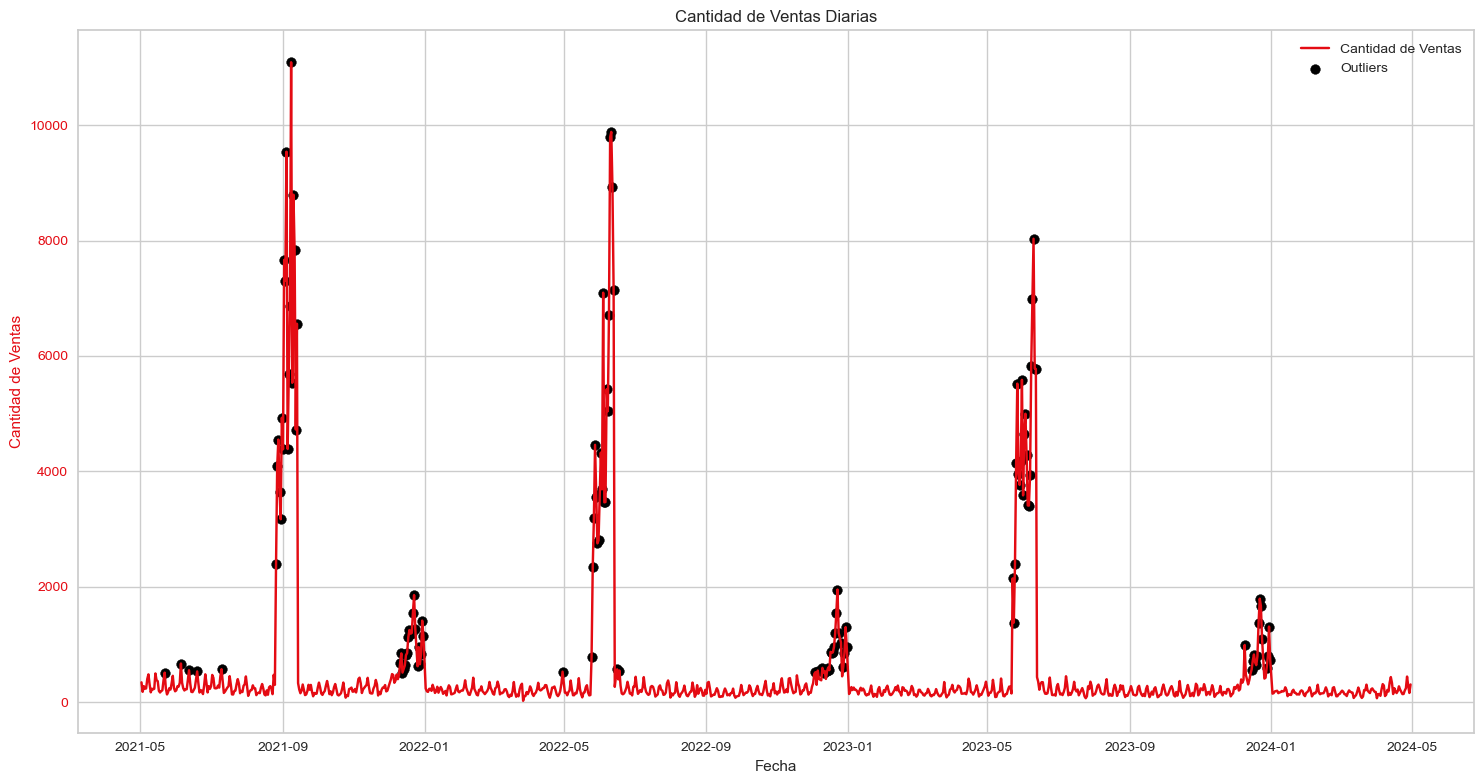

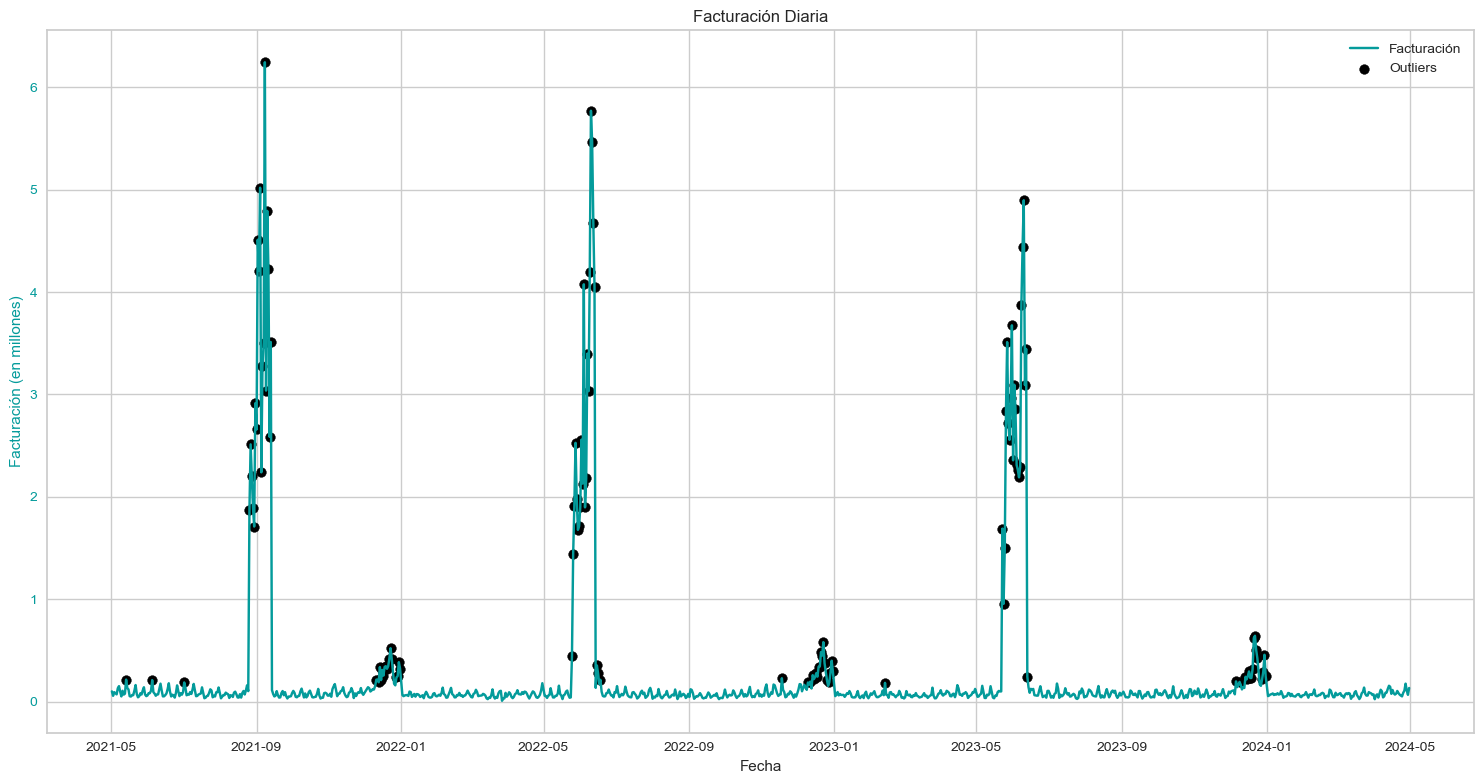

In [16]:
## EVOLUCIÓN FACTURACIÓN, CANTIDADES VENDIDAS POR DIA

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la cantidad de ventas
Q1 = ventas_diarias['Cant_vendidas'].quantile(0.25)
Q3 = ventas_diarias['Cant_vendidas'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

# Creamos el gráfico de líneas para la cantidad de ventas diarias
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Cantidad de Ventas', color=colores_base[0])
ax1.plot(ventas_diarias['Fecha_venta'], ventas_diarias['Cant_vendidas'], color=colores_base[0], label='Cantidad de Ventas')

# Marcamos los valores atípicos
outliers = ventas_diarias[ventas_diarias['Cant_vendidas'] > outlier_threshold]
ax1.scatter(outliers['Fecha_venta'], outliers['Cant_vendidas'], color='black', label='Outliers')
ax1.tick_params(axis='y', labelcolor=colores_base[0])
plt.title('Cantidad de Ventas Diarias')
plt.legend()
plt.tight_layout()
plt.show()

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la facturación
Q1_facturacion = ventas_diarias['Facturacion'].quantile(0.25)
Q3_facturacion = ventas_diarias['Facturacion'].quantile(0.75)
IQR_facturacion = Q3_facturacion - Q1_facturacion
outlier_threshold_facturacion = Q3_facturacion + 1.5 * IQR_facturacion

# Creamos el gráfico de líneas para la facturación diaria
fig, ax2 = plt.subplots(figsize=(15, 8))
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Facturación (en millones)', color=colores_base[1])
ax2.plot(ventas_diarias['Fecha_venta'], ventas_diarias['Facturacion'] / 1e6, color=colores_base[1], label='Facturación')

# Marcamos los valores atípicos para la facturación
outliers_facturacion = ventas_diarias[ventas_diarias['Facturacion'] > outlier_threshold_facturacion]
ax2.scatter(outliers_facturacion['Fecha_venta'], outliers_facturacion['Facturacion'] / 1e6, color='black', label='Outliers')
ax2.tick_params(axis='y', labelcolor=colores_base[1])
plt.title('Facturación Diaria')
plt.legend()
plt.tight_layout()
plt.show()



##### **3.1.3 <ins>Evolución MENSUAL de las ventas</ins>** *(cantidad, facturación y valor de venta promedio)*

In [17]:
## EVOLUCIÓN FACTURACIÓN, CANTIDADES VENDIDAS Y PRECIO MEDIO POR MES

# Creamos nuevas columnas para año y mes
df_merged['Año'] = df_merged['Fecha_venta'].dt.year
df_merged['Mes'] = df_merged['Fecha_venta'].dt.month

# Agrupamos por año y mes y calculamos la cantidad de ventas y la facturación total
ventas_mensuales = df_merged.groupby(['Año', 'Mes']).agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calculamos la facturación con y sin promoción
facturacion_promocion = df_merged.groupby(['Año', 'Mes', 'Promocion']).agg({
    'Facturacion': 'sum'
}).unstack().fillna(0).reset_index()

# Renombramos las columnas
facturacion_promocion.columns = ['Año', 'Mes', 'Facturacion_con_promo', 'Facturacion_sin_promo']

# Calculamos el porcentaje de facturación con y sin promoción
facturacion_promocion['Facturacion_total'] = facturacion_promocion['Facturacion_con_promo'] + facturacion_promocion['Facturacion_sin_promo']
facturacion_promocion['%_Facturacion_sin_promo'] = (facturacion_promocion['Facturacion_sin_promo'] / facturacion_promocion['Facturacion_total']) * 100
facturacion_promocion['%_Facturacion_con_promo'] = (facturacion_promocion['Facturacion_con_promo'] / facturacion_promocion['Facturacion_total']) * 100

# Unimos los datos de facturación con y sin promoción con el dataframe de ventas mensuales
ventas_mensuales = ventas_mensuales.merge(facturacion_promocion, on=['Año', 'Mes'], how='left')

# Calculamos el precio medio
ventas_mensuales['Precio_medio'] = ventas_mensuales['Facturacion'] / ventas_mensuales['Cant_vendidas']

# Formateamos las columnas
ventas_mensuales['Cant_vendidas'] = ventas_mensuales['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_mensuales['Facturacion'] = ventas_mensuales['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_mensuales['Precio_medio'] = ventas_mensuales['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_mensuales['Facturacion_sin_promo'] = ventas_mensuales.apply(lambda row: f"${row['Facturacion_sin_promo']:,.2f} ({row['%_Facturacion_sin_promo']:.1f}%)".replace(',', 'X').replace('.', ',').replace('X', '.'), axis=1)
ventas_mensuales['Facturacion_con_promo'] = ventas_mensuales.apply(lambda row: f"${row['Facturacion_con_promo']:,.2f} ({row['%_Facturacion_con_promo']:.1f}%)".replace(',', 'X').replace('.', ',').replace('X', '.'), axis=1)

# Seleccionamos las columnas deseadas
columnas_deseadas = ['Año', 'Mes', 'Cant_vendidas', 'Facturacion', 'Precio_medio', 'Facturacion_sin_promo', 'Facturacion_con_promo']
ventas_mensuales_formateadas = ventas_mensuales[columnas_deseadas]

# Ordenamos por facturación y seleccionar el top 10
ventas_mensuales_formateadas['Facturacion_numerica'] = ventas_mensuales['Facturacion'].apply(lambda x: float(x.replace('$', '').replace('.', '').replace(',', '.')))
ventas_mensuales_top10 = ventas_mensuales_formateadas.sort_values(by='Facturacion_numerica', ascending=False).head(10).drop(columns=['Facturacion_numerica'])
ventas_mensuales_top10

,Año,Mes,Cant_vendidas,Facturacion,Precio_medio,Facturacion_sin_promo,Facturacion_con_promo
4,2021,9,93.807,"$50.948.964,30","$543,13","$46.355.473,94 (91,0%)","$4.593.490,36 (9,0%)"
13,2022,6,83.269,"$47.387.106,63","$569,08","$1.474.775,11 (3,1%)","$45.912.331,52 (96,9%)"
25,2023,6,65.051,"$38.862.929,04","$597,42","$34.333.988,54 (88,3%)","$4.528.940,50 (11,7%)"
24,2023,5,37.087,"$24.040.056,04","$648,21","$19.998.253,11 (83,2%)","$4.041.802,93 (16,8%)"
3,2021,8,28.205,"$14.944.821,98","$529,86","$12.394.855,25 (82,9%)","$2.549.966,73 (17,1%)"
12,2022,5,24.270,"$13.278.044,72","$547,10","$403.913,76 (3,0%)","$12.874.130,96 (97,0%)"
31,2023,12,19.831,"$7.268.799,64","$366,54","$1.691.987,77 (23,3%)","$5.576.811,87 (76,7%)"
19,2022,12,22.020,"$7.235.031,49","$328,57","$2.529.864,47 (35,0%)","$4.705.167,02 (65,0%)"
7,2021,12,24.020,"$7.185.279,80","$299,14","$1.826.933,10 (25,4%)","$5.358.346,70 (74,6%)"
0,2021,5,8.454,"$2.770.089,20","$327,67","$55.407,00 (2,0%)","$2.714.682,20 (98,0%)"


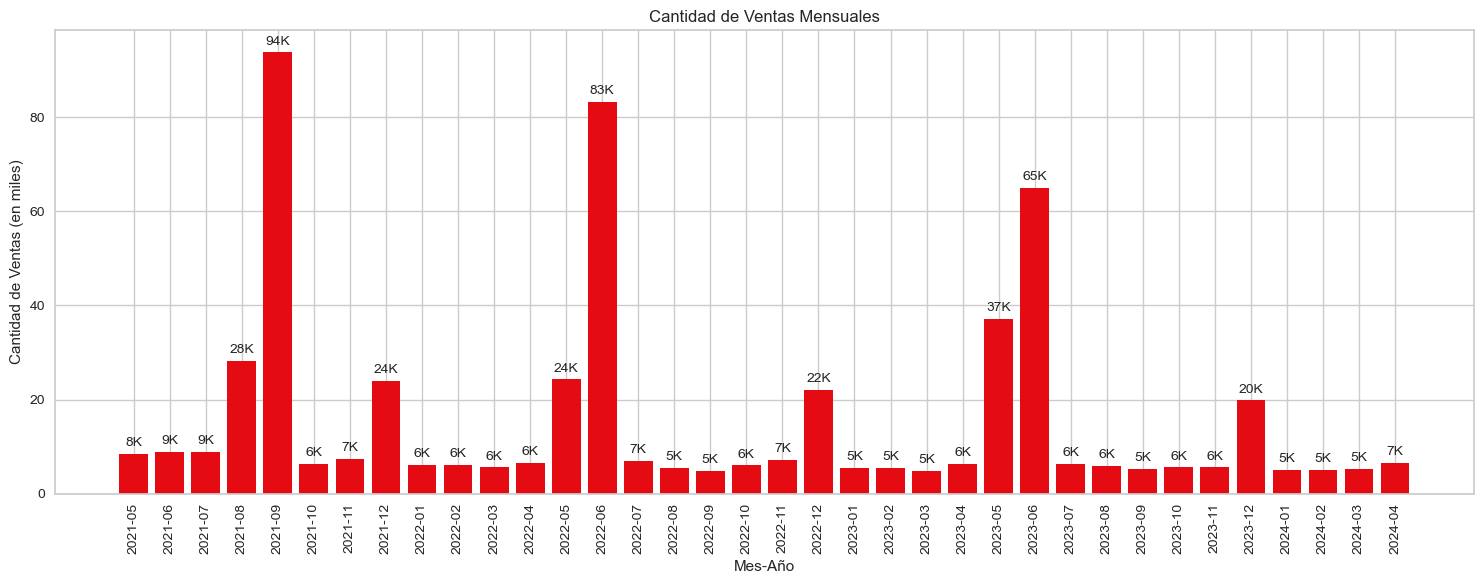

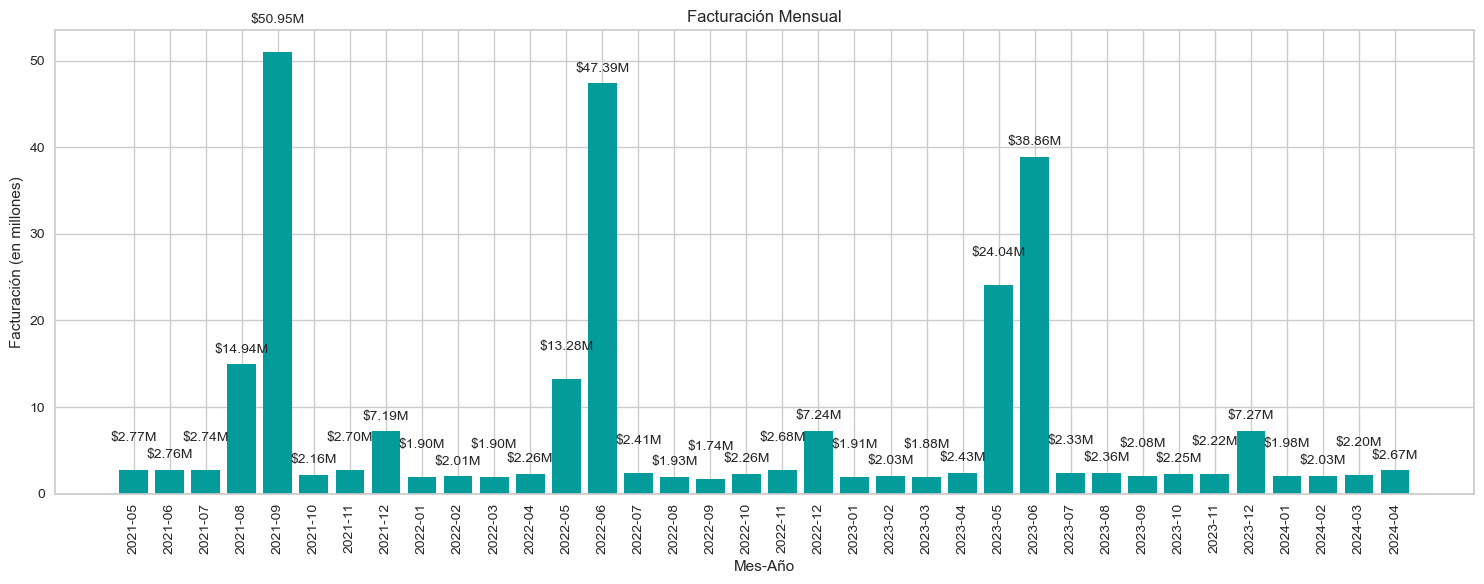

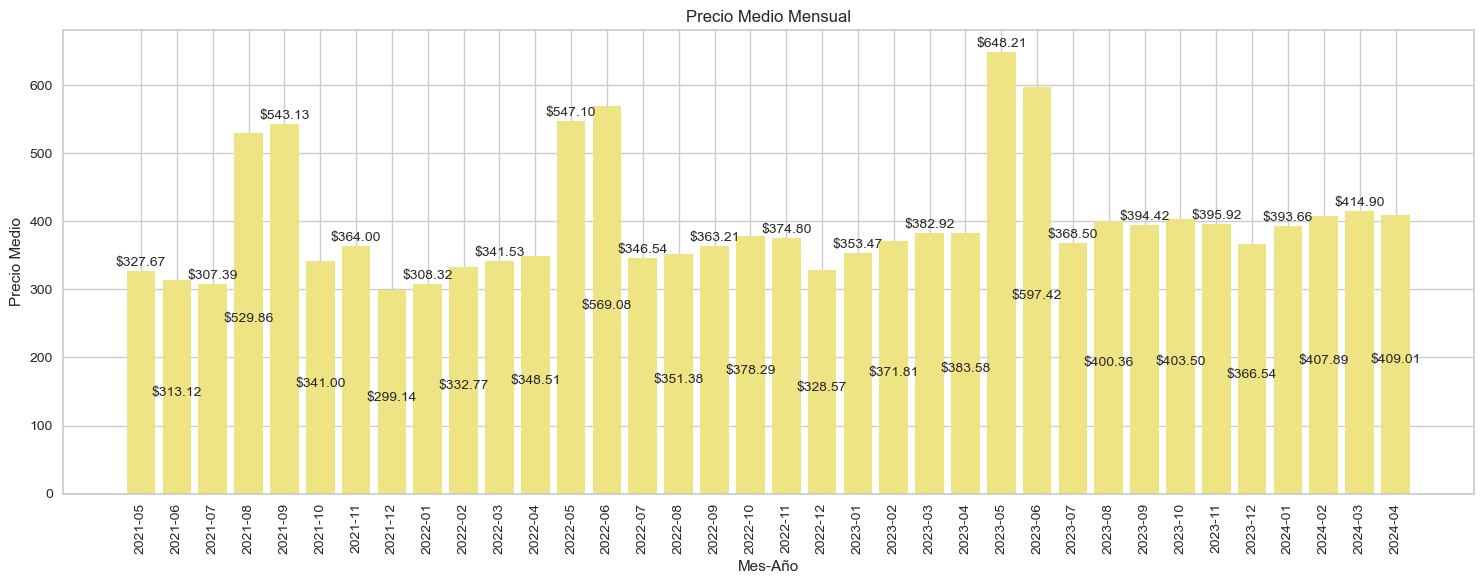

In [18]:
## GRÁFICO FACTURACIÓN, CANTIDADES VENDIDAS Y PRECIO MEDIO POR MES

# Crear una función para graficar barras con colores específicos
def plot_bar_with_colors(ax, data, labels, color, title, ylabel, value_format, scale=1, intercalate=False, all_above=False):
    bars = ax.bar(range(len(labels)), data / scale, color=color)
    for i, (bar, value) in enumerate(zip(bars, data)):
        formatted_value = value_format.format(value / scale).replace(',', '.')
        if all_above:
            va = 'bottom'
            offset = bar.get_height() + 3 if i % 2 == 0 else bar.get_height() + 1
        elif intercalate:
            if i % 2 == 0:
                va = 'bottom'
                offset = bar.get_height() + 3
            else:
                va = 'top'
                offset = bar.get_height() - 3 if title == 'Facturación Mensual' else bar.get_height() / 2
        else:
            va = 'bottom'
            offset = bar.get_height() + 1
        ax.text(bar.get_x() + bar.get_width() / 2, offset, formatted_value,
                ha='center', va=va, fontsize=10)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mes-Año')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)

# Crear la figura y el eje para la cantidad de VENTAS MENSUALES
fig, ax = plt.subplots(figsize=(15, 6))
labels = ventas_mensuales_formateadas.apply(lambda x: f"{int(x['Año'])}-{int(x['Mes']):02d}", axis=1)
data_cant_vendidas = ventas_mensuales_formateadas['Cant_vendidas'].apply(lambda x: int(x.replace('.', '').replace(',', '')))
plot_bar_with_colors(ax, data_cant_vendidas, labels, colores_base[0], 'Cantidad de Ventas Mensuales', 'Cantidad de Ventas (en miles)', '{:,.0f}K', scale=1000)
plt.tight_layout()
plt.show()

# Crear la figura y el eje para la FACTURACIÓN MENSUAL
fig, ax = plt.subplots(figsize=(15, 6))
data_facturacion = ventas_mensuales_formateadas['Facturacion'].apply(lambda x: float(x.replace('$', '').replace('.', '').replace(',', '.')))
plot_bar_with_colors(ax, data_facturacion, labels, colores_base[1], 'Facturación Mensual', 'Facturación (en millones)', '${:,.2f}M', scale=1e6, all_above=True)
plt.tight_layout()
plt.show()

# Crear la figura y el eje para el PRECIO MEDIO MENSUAL
fig, ax = plt.subplots(figsize=(15, 6))
data_precio_medio = ventas_mensuales_formateadas['Precio_medio'].apply(lambda x: float(x.replace('$', '').replace('.', '').replace(',', '.')))
plot_bar_with_colors(ax, data_precio_medio, labels, colores_base[2], 'Precio Medio Mensual', 'Precio Medio', '${:,.2f}', intercalate=True)
plt.tight_layout()
plt.show()



##### **3.1.4 <ins>Evolución SEMANAL de las ventas</ins>** *(cantidad, facturación y valor de venta promedio)*

In [19]:
## EVOLUCIÓN FACTURACIÓN, CANTIDADES VENDIDAS Y PRECIO MEDIO POR SEMANA

# Definimos el orden de los días de la semana
dias_semana_orden = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Agrupamos por día de la semana y calculamos la cantidad de ventas y la facturación total
ventas_semanales = df_merged.groupby('Dia_sem').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reindex(dias_semana_orden).reset_index()

# Calculamos la facturación con y sin promoción
facturacion_promocion_semanal = df_merged.groupby(['Dia_sem', 'Promocion']).agg({
    'Facturacion': 'sum'
}).unstack().fillna(0).reset_index()

# Renombramos las columnas
facturacion_promocion_semanal.columns = ['Dia_sem', 'Facturacion_con_promo', 'Facturacion_sin_promo']

# Calculamos el porcentaje de facturación con y sin promoción
facturacion_promocion_semanal['Facturacion_total'] = facturacion_promocion_semanal['Facturacion_con_promo'] + facturacion_promocion_semanal['Facturacion_sin_promo']
facturacion_promocion_semanal['%_Facturacion_sin_promo'] = (facturacion_promocion_semanal['Facturacion_sin_promo'] / facturacion_promocion_semanal['Facturacion_total']) * 100
facturacion_promocion_semanal['%_Facturacion_con_promo'] = (facturacion_promocion_semanal['Facturacion_con_promo'] / facturacion_promocion_semanal['Facturacion_total']) * 100

# Unimos los datos de facturación con y sin promoción con el dataframe de ventas semanales
ventas_semanales = ventas_semanales.merge(facturacion_promocion_semanal, on='Dia_sem', how='left')

# Calculamos el precio medio
ventas_semanales['Precio_medio'] = ventas_semanales['Facturacion'] / ventas_semanales['Cant_vendidas']

# Formateamos las columnas
ventas_semanales['Cant_vendidas'] = ventas_semanales['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_semanales['Facturacion'] = ventas_semanales['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_semanales['Precio_medio'] = ventas_semanales['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_semanales['Facturacion_sin_promo'] = ventas_semanales.apply(lambda row: f"${row['Facturacion_sin_promo']:,.2f} ({row['%_Facturacion_sin_promo']:.1f}%)".replace(',', 'X').replace('.', ',').replace('X', '.'), axis=1)
ventas_semanales['Facturacion_con_promo'] = ventas_semanales.apply(lambda row: f"${row['Facturacion_con_promo']:,.2f} ({row['%_Facturacion_con_promo']:.1f}%)".replace(',', 'X').replace('.', ',').replace('X', '.'), axis=1)

# Seleccionamos las columnas deseadas
columnas_deseadas = ['Dia_sem', 'Cant_vendidas', 'Facturacion', 'Precio_medio', 'Facturacion_sin_promo', 'Facturacion_con_promo']
ventas_semanales_formateadas = ventas_semanales[columnas_deseadas]

# Ordenamos por el orden de los días de la semana
ventas_semanales_formateadas = ventas_semanales_formateadas.set_index('Dia_sem').reindex(dias_semana_orden).reset_index()

# Mostramos el DataFrame resultante
ventas_semanales_formateadas

,Dia_sem,Cant_vendidas,Facturacion,Precio_medio,Facturacion_sin_promo,Facturacion_con_promo
0,Lunes,67.580,"$33.703.235,97","$498,72","$17.292.737,70 (51,3%)","$16.410.498,27 (48,7%)"
1,Martes,57.601,"$28.723.884,21","$498,67","$12.503.709,18 (43,5%)","$16.220.175,03 (56,5%)"
2,Miércoles,66.742,"$32.843.468,50","$492,10","$16.862.128,38 (51,3%)","$15.981.340,12 (48,7%)"
3,Jueves,76.214,"$38.057.340,91","$499,35","$18.348.033,81 (48,2%)","$19.709.307,10 (51,8%)"
4,Viernes,98.086,"$47.916.850,41","$488,52","$23.080.852,42 (48,2%)","$24.835.997,99 (51,8%)"
5,Sábado,116.642,"$53.765.605,01","$460,95","$23.452.287,75 (43,6%)","$30.313.317,26 (56,4%)"
6,Domingo,81.887,"$36.739.353,20","$448,66","$15.520.110,34 (42,2%)","$21.219.242,86 (57,8%)"


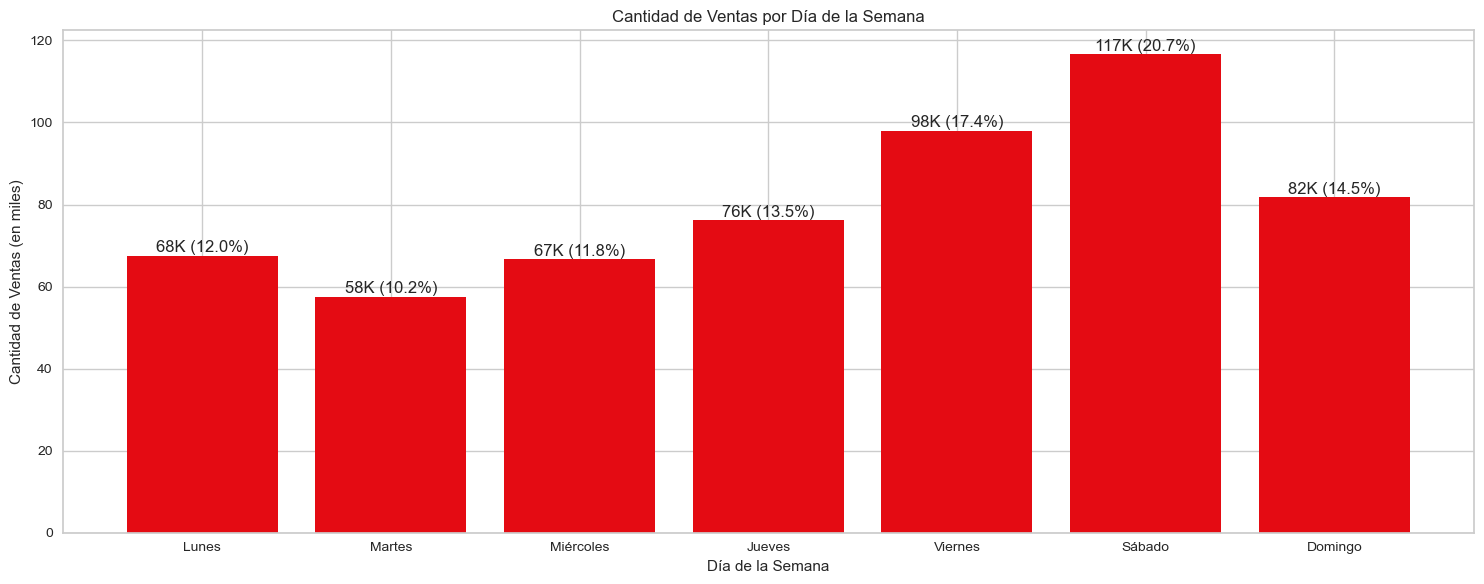

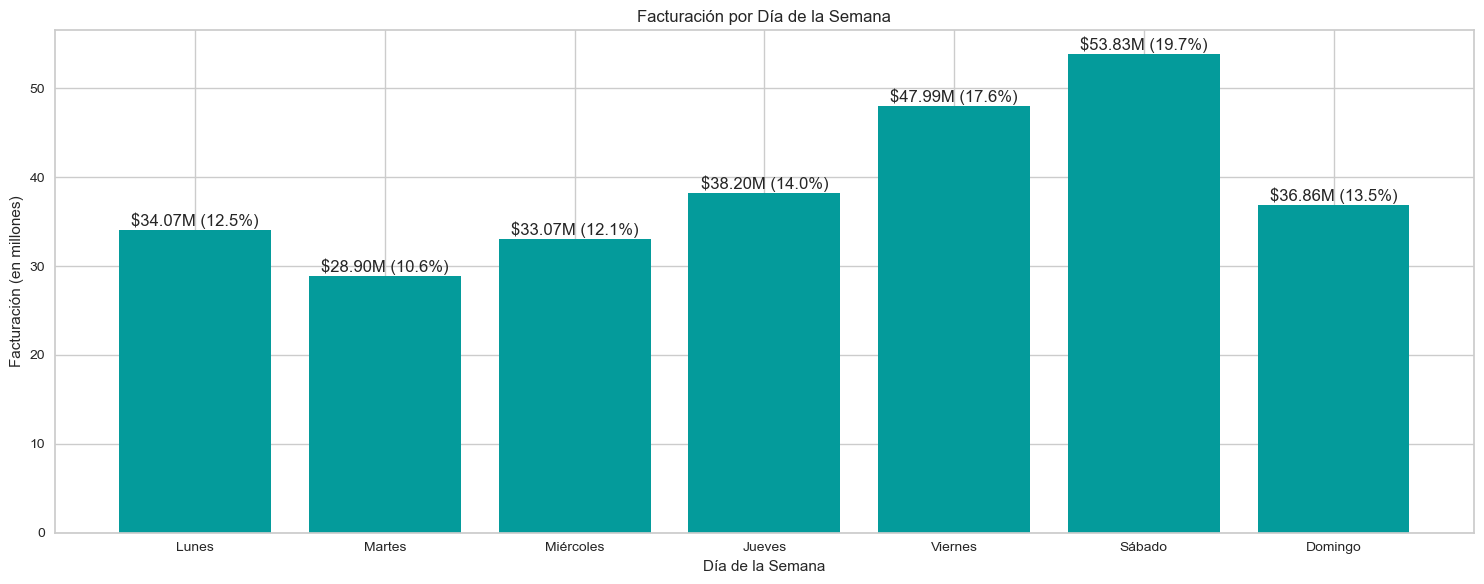

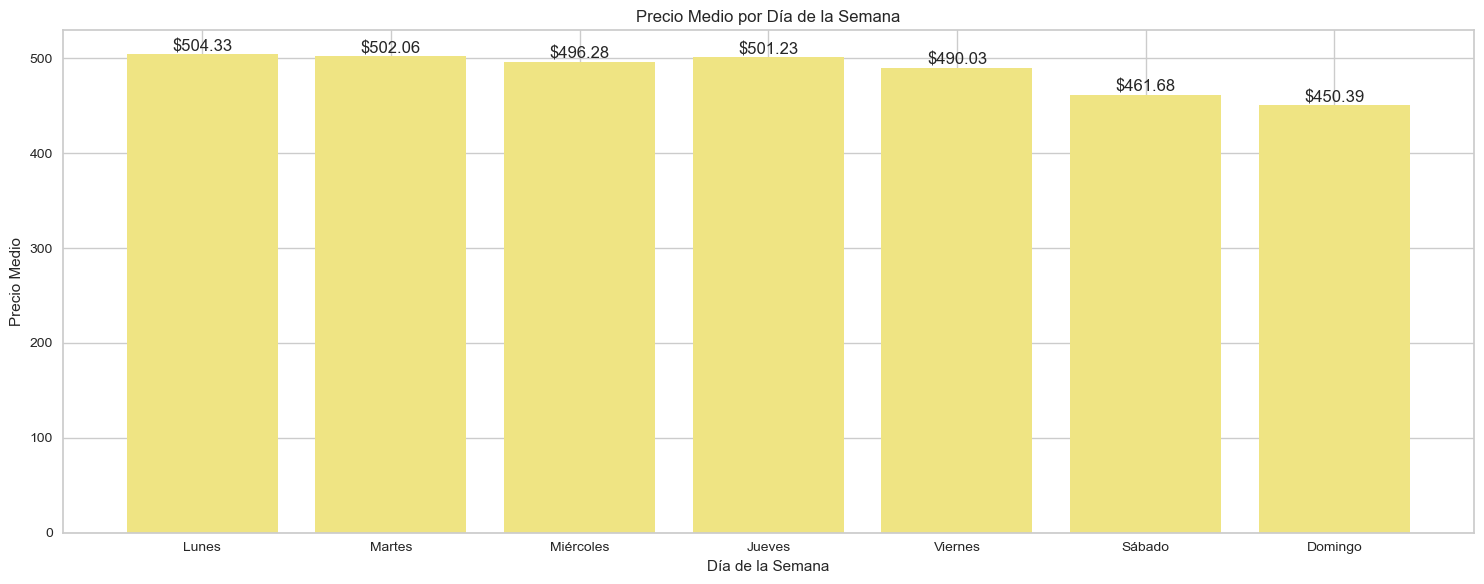

In [20]:
## GRÁFICO FACTURACIÓN, CANTIDADES VENDIDAS Y PRECIO MEDIO POR DÍA DE SEMANA

# Creamos una función para graficar barras con colores específicos
def plot_bar_with_colors_days(ax, data, labels, color, title, ylabel, value_format, scale=1, show_percentage=False, total=None):
    bars = ax.bar(labels, data / scale, color=color)
    for bar, value in zip(bars, data):
        if show_percentage and total:
            percentage = f" ({(value / total * 100):.1f}%)"
        else:
            percentage = ""
        formatted_value = value_format.format(value / scale).replace(',', '.')
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, formatted_value + percentage,
                ha='center', va='bottom', fontsize=12)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Día de la Semana')
    ax.set_xticklabels(labels, rotation=0)

# Ordenamos de los días de la semana
dias_semana_orden = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Graficamos la cantidad de VENTAS POR DÍA DE LA SEMANA
fig, ax = plt.subplots(figsize=(15, 6))
data_cant_vendidas = df_Ventas.groupby('Dia_sem')['Cant_vendidas'].sum().reindex(dias_semana_orden)
total_cant_vendidas = data_cant_vendidas.sum()
plot_bar_with_colors_days(ax, data_cant_vendidas, dias_semana_orden, colores_base[0], 'Cantidad de Ventas por Día de la Semana', 'Cantidad de Ventas (en miles)', '{:,.0f}K', scale=1000, show_percentage=True, total=total_cant_vendidas)
plt.tight_layout()
plt.show()

# Graficamos la FACTURACIÓN POR DÍA DE LA SEMANA
fig, ax = plt.subplots(figsize=(15, 6))
data_facturacion = df_Ventas.groupby('Dia_sem')['Facturacion'].sum().reindex(dias_semana_orden)
total_facturacion = data_facturacion.sum()
plot_bar_with_colors_days(ax, data_facturacion, dias_semana_orden, colores_base[1], 'Facturación por Día de la Semana', 'Facturación (en millones)', '${:,.2f}M', scale=1e6, show_percentage=True, total=total_facturacion)
plt.tight_layout()
plt.show()

# Graficamos el PRECIO MEDIO POR DÍA DE LA SEMANA
fig, ax = plt.subplots(figsize=(15, 6))
data_precio_medio = (df_Ventas.groupby('Dia_sem')['Facturacion'].sum() / df_Ventas.groupby('Dia_sem')['Cant_vendidas'].sum()).reindex(dias_semana_orden)
plot_bar_with_colors_days(ax, data_precio_medio, dias_semana_orden, colores_base[2], 'Precio Medio por Día de la Semana', 'Precio Medio', '${:,.2f}')
plt.tight_layout()
plt.show()



##### **3.1.5 Distribución de ventas <ins>por producto</ins>**

In [21]:
## DISTRIBUCIÓN DE VENTAS POR PRODUCTO

# Contar la cantidad total de productos en toda la base
total_productos = df_merged['ID_producto'].nunique()
print(f"Cantidad total de productos en toda la base: {total_productos}")

# Crear una columna de año en el DataFrame
df_merged['Año'] = df_merged['Fecha_venta'].dt.year

# Contar la cantidad de productos específicos para cada año
productos_por_año = df_merged.groupby('Año')['ID_producto'].nunique().reset_index()
productos_por_año.columns = ['Año', 'Cantidad_productos']
print("\nCantidad de productos específicos por año:")
for index, row in productos_por_año.iterrows():
    print(f"Año: {row['Año']} - Cantidad de productos: {row['Cantidad_productos']}")

## DISTRIBUCIÓN DE VENTAS POR PRODUCTO

# Agrupamos por ID_producto y calculamos la cantidad de ventas y la facturación total
ventas_producto = df_merged.groupby('ID_producto').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calculamos el precio medio
ventas_producto['Precio_medio'] = ventas_producto['Facturacion'] / ventas_producto['Cant_vendidas']

# Calculamos el porcentaje de ventas y facturación por producto
total_cant_vendidas = ventas_producto['Cant_vendidas'].sum()
total_facturacion = ventas_producto['Facturacion'].sum()
ventas_producto['%_Cant_vendidas'] = (ventas_producto['Cant_vendidas'] / total_cant_vendidas) * 100
ventas_producto['%_Facturacion'] = (ventas_producto['Facturacion'] / total_facturacion) * 100

# Ordenamos por cantidad de ventas y seleccionamos el top 10
top_10_cant_vendidas = ventas_producto.sort_values(by='Cant_vendidas', ascending=False).head(10)

# Calculamos el porcentaje acumulado de cantidad vendida y facturación
top_10_cant_vendidas['%_Acumulado_Cant_vendidas'] = top_10_cant_vendidas['%_Cant_vendidas'].cumsum()
top_10_cant_vendidas['%_Acumulado_Facturacion'] = top_10_cant_vendidas['%_Facturacion'].cumsum()

# Ordenamos por facturación y seleccionamos el top 10
top_10_facturacion = ventas_producto.sort_values(by='Facturacion', ascending=False).head(10)

# Calculamos el porcentaje acumulado de cantidad vendida y facturación
top_10_facturacion['%_Acumulado_Cant_vendidas'] = top_10_facturacion['%_Cant_vendidas'].cumsum()
top_10_facturacion['%_Acumulado_Facturacion'] = top_10_facturacion['%_Facturacion'].cumsum()

# Formatear las columnas
top_10_cant_vendidas['Cant_vendidas'] = top_10_cant_vendidas['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
top_10_cant_vendidas['Facturacion'] = top_10_cant_vendidas['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
top_10_cant_vendidas['Precio_medio'] = top_10_cant_vendidas['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
top_10_cant_vendidas['%_Cant_vendidas'] = top_10_cant_vendidas['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_cant_vendidas['%_Facturacion'] = top_10_cant_vendidas['%_Facturacion'].apply(lambda x: f"{x:.1f}%")
top_10_cant_vendidas['%_Acumulado_Cant_vendidas'] = top_10_cant_vendidas['%_Acumulado_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_cant_vendidas['%_Acumulado_Facturacion'] = top_10_cant_vendidas['%_Acumulado_Facturacion'].apply(lambda x: f"{x:.1f}%")

top_10_facturacion['Cant_vendidas'] = top_10_facturacion['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
top_10_facturacion['Facturacion'] = top_10_facturacion['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
top_10_facturacion['Precio_medio'] = top_10_facturacion['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
top_10_facturacion['%_Cant_vendidas'] = top_10_facturacion['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_facturacion['%_Facturacion'] = top_10_facturacion['%_Facturacion'].apply(lambda x: f"{x:.1f}%")
top_10_facturacion['%_Acumulado_Cant_vendidas'] = top_10_facturacion['%_Acumulado_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_facturacion['%_Acumulado_Facturacion'] = top_10_facturacion['%_Acumulado_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Mostramos los DataFrames resultantes
print("\n\nTop 10 PRODUCTOS por CANTIDAD VENDIDA\n")
display(top_10_cant_vendidas)

print("\n\nTop 10 PRODUCTOS por FACTURACIÓN\n")
display(top_10_facturacion)

Cantidad total de productos en toda la base: 1469

Cantidad de productos específicos por año:
Año: 2021 - Cantidad de productos: 1080
Año: 2022 - Cantidad de productos: 1159
Año: 2023 - Cantidad de productos: 1271
Año: 2024 - Cantidad de productos: 1068


Top 10 PRODUCTOS por CANTIDAD VENDIDA



,ID_producto,Cant_vendidas,Facturacion,Precio_medio,%_Cant_vendidas,%_Facturacion,%_Acumulado_Cant_vendidas,%_Acumulado_Facturacion
228,560978,12.188,"$5.733.059,75","$470,39",2.2%,2.1%,2.2%,2.1%
177,560779,10.087,"$2.660.533,75","$263,76",1.8%,1.0%,3.9%,3.1%
1444,607467,7.423,"$2.006.479,53","$270,31",1.3%,0.7%,5.3%,3.8%
1441,607433,6.954,"$1.931.250,88","$277,72",1.2%,0.7%,6.5%,4.5%
306,561278,6.345,"$4.603.113,02","$725,47",1.1%,1.7%,7.6%,6.2%
324,561395,5.181,"$2.962.153,70","$571,73",0.9%,1.1%,8.5%,7.3%
20,560032,5.000,"$2.084.154,89","$416,83",0.9%,0.8%,9.4%,8.1%
961,562622,4.975,"$2.254.044,73","$453,07",0.9%,0.8%,10.3%,8.9%
190,560849,4.532,"$3.269.778,79","$721,49",0.8%,1.2%,11.1%,10.1%
1397,604237,4.479,"$1.096.704,77","$244,85",0.8%,0.4%,11.9%,10.5%




Top 10 PRODUCTOS por FACTURACIÓN



,ID_producto,Cant_vendidas,Facturacion,Precio_medio,%_Cant_vendidas,%_Facturacion,%_Acumulado_Cant_vendidas,%_Acumulado_Facturacion
228,560978,12.188,"$5.733.059,75","$470,39",2.2%,2.1%,2.2%,2.1%
306,561278,6.345,"$4.603.113,02","$725,47",1.1%,1.7%,3.3%,3.8%
190,560849,4.532,"$3.269.778,79","$721,49",0.8%,1.2%,4.1%,5.0%
395,561636,2.514,"$3.196.995,03","$1.271,68",0.4%,1.2%,4.5%,6.2%
324,561395,5.181,"$2.962.153,70","$571,73",0.9%,1.1%,5.4%,7.3%
177,560779,10.087,"$2.660.533,75","$263,76",1.8%,1.0%,7.2%,8.3%
1415,605097,4.139,"$2.477.359,12","$598,54",0.7%,0.9%,8.0%,9.2%
833,562466,2.828,"$2.431.757,51","$859,89",0.5%,0.9%,8.5%,10.1%
671,562217,1.563,"$2.429.071,84","$1.554,11",0.3%,0.9%,8.7%,11.0%
961,562622,4.975,"$2.254.044,73","$453,07",0.9%,0.8%,9.6%,11.8%


Los productos etiquetados se encuentran en alguno de los Top 10 por facturación o cantidades vendidas.


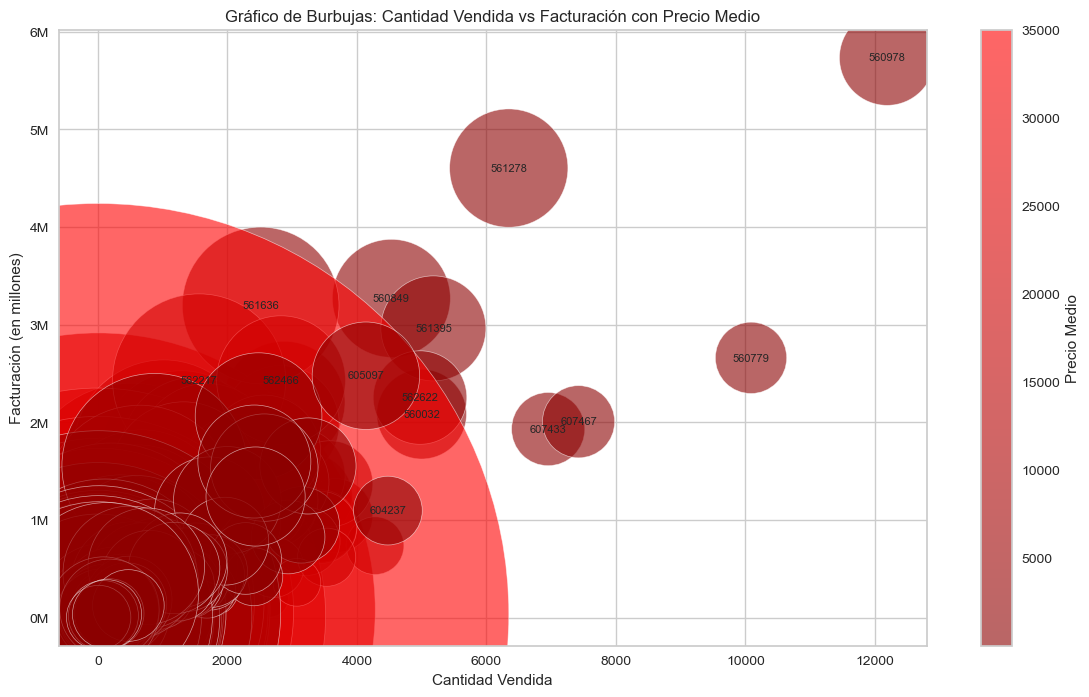

In [22]:
## GRÁFICO DE BURBUJAS POR PRODUCTO

# Obtener el top 10 por cantidad vendida y facturación
top_10_cant_vendidas = ventas_producto.sort_values(by='Cant_vendidas', ascending=False).head(10)
top_10_facturacion = ventas_producto.sort_values(by='Facturacion', ascending=False).head(10)

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(14, 8))

# Definir una paleta de colores en degradado de rojo oscuro a rojo claro
colors = ['#8B0000', '#FF0000']
paleta = LinearSegmentedColormap.from_list("rojo_degrade", colors)

# Crear el gráfico de burbujas
bubble = ax.scatter(
    ventas_producto['Cant_vendidas'],
    ventas_producto['Facturacion'],
    s=ventas_producto['Precio_medio'] * 10,  # Ajustar el tamaño de las burbujas si es necesario
    c=ventas_producto['Precio_medio'],
    cmap=paleta,
    alpha=0.6,
    edgecolors="w",
    linewidth=0.5
)

# Añadir la barra de color
cbar = plt.colorbar(bubble)
cbar.set_label('Precio Medio')

# Configurar los ejes y el título
ax.set_xlabel('Cantidad Vendida')
ax.set_ylabel('Facturación (en millones)')
ax.set_title('Gráfico de Burbujas: Cantidad Vendida vs Facturación con Precio Medio')

# Ajustar el eje de facturación para mostrar en millones
formatter = plt.FuncFormatter(lambda x, pos: f'{int(x / 1e6)}M')
ax.yaxis.set_major_formatter(formatter)

# Mostrar el mensaje antes del gráfico
print("Los productos etiquetados se encuentran en alguno de los Top 10 por facturación o cantidades vendidas.")

# Añadir anotaciones solo para los productos en el top 10
for i in range(ventas_producto.shape[0]):
    if (ventas_producto['ID_producto'][i] in top_10_cant_vendidas['ID_producto'].values) or \
       (ventas_producto['ID_producto'][i] in top_10_facturacion['ID_producto'].values):
        ax.annotate(ventas_producto['ID_producto'][i],
                    (ventas_producto['Cant_vendidas'][i], ventas_producto['Facturacion'][i]),
                    fontsize=8, ha='center', va='center')

# Mostrar el gráfico
plt.grid(True)
plt.show()

Los productos etiquetados se encuentran en alguno de los Top 10 por facturación o cantidades vendidas.


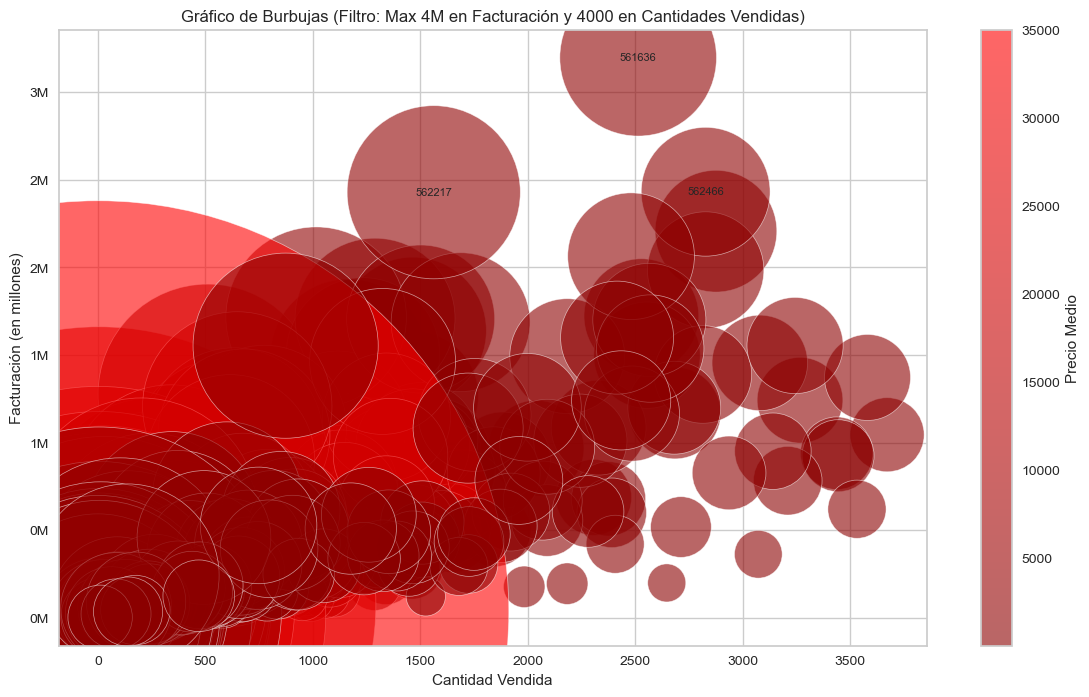

In [23]:
## GRÁFICO DE BURBUJAS POR PRODUCTO CON LIMITE DE 4M EN FACTURACIÓN Y 4.000 EN CANTIDADES VENDIDAS

# Filtramos productos con un máximo de 4 millones en facturación y 4000 en cantidades vendidas
filtered_productos = ventas_producto[(ventas_producto['Facturacion'] <= 4e6) & (ventas_producto['Cant_vendidas'] <= 4000)]

# Creamos una figura y un eje
fig, ax = plt.subplots(figsize=(14, 8))

# Creamos el gráfico de burbujas
bubble = ax.scatter(
    filtered_productos['Cant_vendidas'],
    filtered_productos['Facturacion'],
    s=filtered_productos['Precio_medio'] * 10,
    c=filtered_productos['Precio_medio'],
    cmap=paleta,
    alpha=0.6,
    edgecolors="w",
    linewidth=0.5
)

# Añadimos la barra de color
cbar = plt.colorbar(bubble)
cbar.set_label('Precio Medio')

# Configuramos los ejes y el título
ax.set_xlabel('Cantidad Vendida')
ax.set_ylabel('Facturación (en millones)')
ax.set_title('Gráfico de Burbujas (Filtro: Max 4M en Facturación y 4000 en Cantidades Vendidas)')

# Ajustamos el eje de facturación para mostrar en millones
formatter = plt.FuncFormatter(lambda x, pos: f'{int(x / 1e6)}M')
ax.yaxis.set_major_formatter(formatter)

# Mostramos el mensaje antes del gráfico
print("Los productos etiquetados se encuentran en alguno de los Top 10 por facturación o cantidades vendidas.")

# Añadimos anotaciones solo para los productos en el top 10 dentro del filtro
for i in range(filtered_productos.shape[0]):
    if (filtered_productos['ID_producto'].iloc[i] in top_10_cant_vendidas['ID_producto'].values) or \
       (filtered_productos['ID_producto'].iloc[i] in top_10_facturacion['ID_producto'].values):
        ax.annotate(filtered_productos['ID_producto'].iloc[i],
                    (filtered_productos['Cant_vendidas'].iloc[i], filtered_productos['Facturacion'].iloc[i]),
                    fontsize=8, ha='center', va='center')

# Mostramos el gráfico
plt.grid(True)
plt.show()



##### **3.1.6 Distribución de ventas <ins>por categoría</ins>**

In [24]:
## DISTRIBUCIÓN DE VENTAS POR CATEGORÍA

# Ordenamos los días de la semana
dias_semana_orden = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Agrupamos por categoría y calcular la cantidad de ventas y la facturación total
ventas_categoria = df_merged.groupby('Categoria').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calculamos el precio medio
ventas_categoria['Precio_medio'] = ventas_categoria['Facturacion'] / ventas_categoria['Cant_vendidas']

# Calculamos el porcentaje de ventas y facturación por categoría
total_cant_vendidas = ventas_categoria['Cant_vendidas'].sum()
total_facturacion = ventas_categoria['Facturacion'].sum()
ventas_categoria['%_Cant_vendidas'] = (ventas_categoria['Cant_vendidas'] / total_cant_vendidas) * 100
ventas_categoria['%_Facturacion'] = (ventas_categoria['Facturacion'] / total_facturacion) * 100

# Formateamos las columnas
ventas_categoria['Cant_vendidas'] = ventas_categoria['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_categoria['Facturacion'] = ventas_categoria['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_categoria['Precio_medio'] = ventas_categoria['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_categoria['%_Cant_vendidas'] = ventas_categoria['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
ventas_categoria['%_Facturacion'] = ventas_categoria['%_Facturacion'].apply(lambda x: f"{x:.1f}%")

print("\n\nDistribución de CANTIDADES VENDIDAS y FACTURACIÓN por CATEGORIA\n")
display(ventas_categoria)

# Agrupamos por categoría y día de la semana, y calculamos la cantidad de ventas y la facturación total
ventas_categoria_dia = df_merged.groupby(['Categoria', 'Dia_sem']).agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calculamos el precio medio
ventas_categoria_dia['Precio_medio'] = ventas_categoria_dia['Facturacion'] / ventas_categoria_dia['Cant_vendidas']

# Calculamos el porcentaje de ventas y facturación por categoría y día de la semana
total_cant_vendidas = ventas_categoria_dia.groupby('Dia_sem')['Cant_vendidas'].transform('sum')
total_facturacion = ventas_categoria_dia.groupby('Dia_sem')['Facturacion'].transform('sum')
ventas_categoria_dia['%_Cant_vendidas'] = (ventas_categoria_dia['Cant_vendidas'] / total_cant_vendidas) * 100
ventas_categoria_dia['%_Facturacion'] = (ventas_categoria_dia['Facturacion'] / total_facturacion) * 100

# Formateamos las columnas
ventas_categoria_dia['Cant_vendidas'] = ventas_categoria_dia['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_categoria_dia['Facturacion'] = ventas_categoria_dia['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_categoria_dia['Precio_medio'] = ventas_categoria_dia['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_categoria_dia['%_Cant_vendidas'] = ventas_categoria_dia['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
ventas_categoria_dia['%_Facturacion'] = ventas_categoria_dia['%_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Reordenamos los días de la semana
ventas_categoria_dia['Dia_sem'] = pd.Categorical(ventas_categoria_dia['Dia_sem'], categories=dias_semana_orden, ordered=True)
ventas_categoria_dia = ventas_categoria_dia.sort_values(['Dia_sem', 'Categoria'])

# Reorganizamos las columnas para mostrar primero el día de la semana
ventas_categoria_dia = ventas_categoria_dia[['Dia_sem', 'Categoria', 'Cant_vendidas', 'Facturacion', 'Precio_medio', '%_Cant_vendidas', '%_Facturacion']]

# Mostramos el DataFrame resultante
print("\n\nDistribución de CANTIDADES VENDIDAS y FACTURACIÓN por CATEGORIA y DÍA DE SEMANA\n")
display(ventas_categoria_dia)



Distribución de CANTIDADES VENDIDAS y FACTURACIÓN por CATEGORIA



,Categoria,Cant_vendidas,Facturacion,Precio_medio,%_Cant_vendidas,%_Facturacion
0,216,493.888,"$244.509.678,51","$495,07",87.5%,90.0%
1,217,70.864,"$27.240.059,70","$384,40",12.5%,10.0%




Distribución de CANTIDADES VENDIDAS y FACTURACIÓN por CATEGORIA y DÍA DE SEMANA



,Dia_sem,Categoria,Cant_vendidas,Facturacion,Precio_medio,%_Cant_vendidas,%_Facturacion
2,Lunes,216,58.886,"$30.315.614,59","$514,82",87.1%,89.9%
9,Lunes,217,8.694,"$3.387.621,38","$389,65",12.9%,10.1%
3,Martes,216,50.329,"$25.760.870,98","$511,85",87.4%,89.7%
10,Martes,217,7.272,"$2.963.013,23","$407,46",12.6%,10.3%
4,Miércoles,216,58.047,"$29.301.168,76","$504,78",87.0%,89.2%
11,Miércoles,217,8.695,"$3.542.299,74","$407,40",13.0%,10.8%
1,Jueves,216,65.421,"$33.815.584,17","$516,89",85.8%,88.9%
8,Jueves,217,10.793,"$4.241.756,74","$393,01",14.2%,11.1%
6,Viernes,216,84.749,"$42.664.682,78","$503,42",86.4%,89.0%
13,Viernes,217,13.337,"$5.252.167,63","$393,80",13.6%,11.0%




##### **3.1.7 Distribución de ventas <ins>por proveedor</ins>**

In [25]:
## DISTRIBUCIÓN DE VENTAS POR PROVEEDOR

# Total de proveedores
total_proveedores = df_merged['ID_proveedor'].nunique()
print(f"Cantidad total de proveedores: {total_proveedores}")

# Cantidad de proveedores por año
df_merged['Año'] = df_merged['Fecha_venta'].dt.year
proveedores_por_año = df_merged.groupby('Año')['ID_proveedor'].nunique().reset_index()
proveedores_por_año.columns = ['Año', 'Cantidad_proveedores']

print("\nCantidad de Proveedores por Año:")
display(proveedores_por_año)

# Agrupar por proveedor y calcular la cantidad de ventas y la facturación total
ventas_proveedor = df_merged.groupby('ID_proveedor').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calcular el precio medio
ventas_proveedor['Precio_medio'] = ventas_proveedor['Facturacion'] / ventas_proveedor['Cant_vendidas']

# Calcular el porcentaje de ventas y facturación por proveedor
total_cant_vendidas = ventas_proveedor['Cant_vendidas'].sum()
total_facturacion = ventas_proveedor['Facturacion'].sum()
ventas_proveedor['%_Cant_vendidas'] = (ventas_proveedor['Cant_vendidas'] / total_cant_vendidas) * 100
ventas_proveedor['%_Facturacion'] = (ventas_proveedor['Facturacion'] / total_facturacion) * 100

# Formatear las columnas para la visualización
ventas_proveedor_formatted = ventas_proveedor.copy()
ventas_proveedor_formatted['Cant_vendidas'] = ventas_proveedor_formatted['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
ventas_proveedor_formatted['Facturacion'] = ventas_proveedor_formatted['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_proveedor_formatted['Precio_medio'] = ventas_proveedor_formatted['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
ventas_proveedor_formatted['%_Cant_vendidas'] = ventas_proveedor_formatted['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
ventas_proveedor_formatted['%_Facturacion'] = ventas_proveedor_formatted['%_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Top 10 proveedores por cantidad vendida
top_10_cant_vendidas = ventas_proveedor.sort_values(by='Cant_vendidas', ascending=False).head(10)

# Calcular el porcentaje acumulado de cantidad vendida y facturación
top_10_cant_vendidas['%_Acumulado_Cant_vendidas'] = top_10_cant_vendidas['%_Cant_vendidas'].cumsum()
top_10_cant_vendidas['%_Acumulado_Facturacion'] = top_10_cant_vendidas['%_Facturacion'].cumsum()

# Formatear los porcentajes y precio medio en el top 10 de cantidad vendida
top_10_cant_vendidas['%_Cant_vendidas'] = top_10_cant_vendidas['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_cant_vendidas['%_Facturacion'] = top_10_cant_vendidas['%_Facturacion'].apply(lambda x: f"{x:.1f}%")
top_10_cant_vendidas['Precio_medio'] = top_10_cant_vendidas['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
top_10_cant_vendidas['%_Acumulado_Cant_vendidas'] = top_10_cant_vendidas['%_Acumulado_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_cant_vendidas['%_Acumulado_Facturacion'] = top_10_cant_vendidas['%_Acumulado_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Top 10 proveedores por facturación
top_10_facturacion = ventas_proveedor.sort_values(by='Facturacion', ascending=False).head(10)

# Calcular el porcentaje acumulado de cantidad vendida y facturación
top_10_facturacion['%_Acumulado_Cant_vendidas'] = top_10_facturacion['%_Cant_vendidas'].cumsum()
top_10_facturacion['%_Acumulado_Facturacion'] = top_10_facturacion['%_Facturacion'].cumsum()

# Formatear los porcentajes y precio medio en el top 10 de facturación
top_10_facturacion['%_Cant_vendidas'] = top_10_facturacion['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_facturacion['%_Facturacion'] = top_10_facturacion['%_Facturacion'].apply(lambda x: f"{x:.1f}%")
top_10_facturacion['Precio_medio'] = top_10_facturacion['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
top_10_facturacion['%_Acumulado_Cant_vendidas'] = top_10_facturacion['%_Acumulado_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
top_10_facturacion['%_Acumulado_Facturacion'] = top_10_facturacion['%_Acumulado_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Proveedores con menos del 1% de las cantidades vendidas
proveedores_menos_1_cant_vendidas = ventas_proveedor[ventas_proveedor['%_Cant_vendidas'] < 1].shape[0]

# Proveedores con menos del 1% de la facturación
proveedores_menos_1_facturacion = ventas_proveedor[ventas_proveedor['%_Facturacion'] < 1].shape[0]

print(f"\n\nCantidad de proveedores que representan menos del 1% de las cantidades vendidas: {proveedores_menos_1_cant_vendidas}")
print(f"Cantidad de proveedores que representan menos del 1% de la facturación: {proveedores_menos_1_facturacion}")

print("\n\nTop 10 PROVEEDORES por CANTIDAD VENDIDA\n")
display(top_10_cant_vendidas)

print("\n\nTop 10 PROVEEDORES por FACTURACIÓN\n")
display(top_10_facturacion)

Cantidad total de proveedores: 79

Cantidad de Proveedores por Año:


,Año,Cantidad_proveedores
0,2021,65
1,2022,64
2,2023,71
3,2024,64




Cantidad de proveedores que representan menos del 1% de las cantidades vendidas: 55
Cantidad de proveedores que representan menos del 1% de la facturación: 60


Top 10 PROVEEDORES por CANTIDAD VENDIDA



,ID_proveedor,Cant_vendidas,Facturacion,Precio_medio,%_Cant_vendidas,%_Facturacion,%_Acumulado_Cant_vendidas,%_Acumulado_Facturacion
2,10214,124825,52191284.52,"$418,12",22.1%,19.2%,22.1%,19.2%
25,22049,60494,39102336.79,"$646,38",10.7%,14.4%,32.8%,33.6%
24,22010,52329,28964571.73,"$553,51",9.3%,10.7%,42.1%,44.3%
1,10145,29810,18564037.22,"$622,75",5.3%,6.8%,47.4%,51.1%
43,62707,22175,12683856.25,"$571,99",3.9%,4.7%,51.3%,55.8%
37,31064,16799,4450108.04,"$264,90",3.0%,1.6%,54.3%,57.4%
58,65987,16559,4695646.07,"$283,57",2.9%,1.7%,57.2%,59.1%
38,31066,16134,7821494.54,"$484,78",2.9%,2.9%,60.0%,62.0%
14,12002,14878,8242860.36,"$554,03",2.6%,3.0%,62.7%,65.0%
29,25161,14545,10499129.41,"$721,84",2.6%,3.9%,65.3%,68.9%




Top 10 PROVEEDORES por FACTURACIÓN



,ID_proveedor,Cant_vendidas,Facturacion,Precio_medio,%_Cant_vendidas,%_Facturacion,%_Acumulado_Cant_vendidas,%_Acumulado_Facturacion
2,10214,124825,52191284.52,"$418,12",22.1%,19.2%,22.1%,19.2%
25,22049,60494,39102336.79,"$646,38",10.7%,14.4%,32.8%,33.6%
24,22010,52329,28964571.73,"$553,51",9.3%,10.7%,42.1%,44.3%
1,10145,29810,18564037.22,"$622,75",5.3%,6.8%,47.4%,51.1%
43,62707,22175,12683856.25,"$571,99",3.9%,4.7%,51.3%,55.8%
26,22231,14247,11246245.94,"$789,38",2.5%,4.1%,53.8%,59.9%
29,25161,14545,10499129.41,"$721,84",2.6%,3.9%,56.4%,63.8%
14,12002,14878,8242860.36,"$554,03",2.6%,3.0%,59.0%,66.8%
38,31066,16134,7821494.54,"$484,78",2.9%,2.9%,61.9%,69.7%
44,62829,9619,7026551.62,"$730,49",1.7%,2.6%,63.6%,72.3%




##### **3.1.8 <ins>Status tipo de proveedor</ins>**

In [26]:
## DISTRIBUCIÓN DE VENTAS POR PROVEEDOR

# Reclasificamos los valores de "Clasif_proveedor"
df_merged['Clasif_proveedor'] = df_merged['Clasif_proveedor'].replace({
    1: 'Proveedor Externo',
    3: 'Logístico'
})

# Contamos la cantidad de proveedores en cada categoría de "Clasif_proveedor"
clasif_proveedor_counts = df_merged['Clasif_proveedor'].value_counts().reset_index()
clasif_proveedor_counts.columns = ['Clasif_proveedor', 'Cantidad']

# Mostramos el DataFrame resultante
print("\n\nCantidad de Proveedores en cada Categoría de Clasificación\n")
display(clasif_proveedor_counts)



Cantidad de Proveedores en cada Categoría de Clasificación



,Clasif_proveedor,Cantidad
0,1,143966




##### **3.1.9 <ins>Status productos vendidos</ins>**

In [27]:
## DISTRIBUCIÓN DE STATUS PRODUCTOS VENDIDOS

# Agrupar por status y calcular la cantidad de ventas, facturación total y precio medio
analisis_status = df_merged.groupby('Status').agg({
    'Cant_vendidas': 'sum',
    'Facturacion': 'sum'
}).reset_index()

# Calcular el precio medio
analisis_status['Precio_medio'] = analisis_status['Facturacion'] / analisis_status['Cant_vendidas']

# Calcular el porcentaje de ventas y facturación por status
total_cant_vendidas = analisis_status['Cant_vendidas'].sum()
total_facturacion = analisis_status['Facturacion'].sum()
analisis_status['%_Cant_vendidas'] = (analisis_status['Cant_vendidas'] / total_cant_vendidas) * 100
analisis_status['%_Facturacion'] = (analisis_status['Facturacion'] / total_facturacion) * 100

# Formatear las columnas para la visualización
analisis_status['Cant_vendidas'] = analisis_status['Cant_vendidas'].apply(lambda x: f"{x:,}".replace(',', '.'))
analisis_status['Facturacion'] = analisis_status['Facturacion'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
analisis_status['Precio_medio'] = analisis_status['Precio_medio'].apply(lambda x: f"${x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
analisis_status['%_Cant_vendidas'] = analisis_status['%_Cant_vendidas'].apply(lambda x: f"{x:.1f}%")
analisis_status['%_Facturacion'] = analisis_status['%_Facturacion'].apply(lambda x: f"{x:.1f}%")

# Mostrar el DataFrame resultante
print("\n\nAnálisis por Status\n")
display(analisis_status)



Análisis por Status



,Status,Cant_vendidas,Facturacion,Precio_medio,%_Cant_vendidas,%_Facturacion
0,1,479.416,"$225.888.188,59","$471,17",84.9%,83.1%
1,5,85.336,"$45.861.549,62","$537,42",15.1%,16.9%


### **Primeras concluciones estadísticas**

- Para **varios días** de los períodos: **<ins>Setiempre 2021</ins>, <ins>Junio 2022</ins> y <ins>Julio 2023</ins>** se observan **<ins>facturaciones y cantidades vendidas atípicas</ins>**. Se entiende que estos comportamientos resultan atípicos y no tienen una explicación en la estacionalidad en las ventas *(como si sucede con las ventas de los meses de diciembre)*.

- **La mayor cantidad de ventas *(tanto en cantidad como en facturación)* se registran los días <ins>viernes</ins> y <ins>sábado</ins>**. Los siguientes días con más ventas son los domingos y los lunes. **<ins>los dias de semana</ins>** se registran el **<ins>menor volumen de ventas</ins>**.

- El **<ins>precio medio por venta</ins> es relativamente <ins>constante entre lunes y jueves</ins>**. En los días **<ins>viernes</ins>, <ins>sábado</ins> y <ins>domingo</ins> el <ins>precio medio desciente</ins>** día tras día hasta llegar a la franja de los $450.

- **La <ins>categoría 216 (Vinos Finos)</ins> significa el <ins>87,5% del total de ventas</ins> y el <ins>90% de la facturación</ins>**. El resto de las ventas corresponden a la categoría 217 (Espumantes). **No se observan variaciones significativas en la distribución de las ventas entre días de semana**.

- **Se detecta una <ins>gran concentración de las ventas en torno a 5 proveedores</ins>, tanto desde la óptica de cantidades vendidas (51,3%) con el la facturación (55,8%)**. **El TOP 5 de provedores es el mismo tanto si se observa la facturación como las cantidades vendidas**: 10214, 22049, 22010, 10145, 62707.

- Del **<ins>total de 79 proveedores</ins> que se registran en las ventas**, **<ins>55 de ellos registran menos del 1% de las ventas</ins>** y <ins>60 de menos del 1% de la facturación total</ins>. Este dato, sumado a lo expuesto en el punto anterior, permiten afirmar que **las <ins>ventas se concentran mayormente en pocos proveedores</ins>**.

- En base solamente se registra un **solo tipo de proveedor: <ins>'Externo'</ins>**.

- **El 15% de los productos vendidos históricamente se encuentran <ins>congelados</ins>**: es decir que no se encuentran más disponibles a la venta.

---

# **4. <ins>Depuración del Dataframe</ins>**



### **4.1 <ins>Eliminación de ventas</ins>**



##### **4.1.1 Eliminación de productos <ins>no a la venta</ins>** *(Stautus != 1)*

In [28]:
# Contamos el número de ventas antes de la eliminación
ventas_antes = df_merged.shape[0]

# Eliminamos filas donde el valor de la columna 'Status' sea distinto de 1
df_merged = df_merged[df_merged['Status'] == "1"]

# Contamos el número de ventas después de la eliminación
ventas_despues = df_merged.shape[0]

# Calculamos el número de ventas eliminadas
ventas_eliminadas = ventas_antes - ventas_despues

# Mostramos los resultados
print(f"Cantidad de ventas eliminadas: {ventas_eliminadas}")
print(f"Cantidad de ventas conservadas: {ventas_despues}")
print("\nDataframe Resultante\n")
display(df_merged.head())

Cantidad de ventas eliminadas: 24937
Cantidad de ventas conservadas: 119029

Dataframe Resultante



,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion,Año,Mes
0,5201,2021-05-02,600790,7,1393.0,199.0,Domingo,1,31064,216,1,No,2021,5
1,5201,2021-05-02,600793,2,390.0,195.0,Domingo,1,31064,216,1,No,2021,5
2,5201,2021-05-02,600794,7,2023.0,289.0,Domingo,1,31064,216,1,No,2021,5
3,5201,2021-05-02,605089,1,399.0,399.0,Domingo,1,22010,216,1,No,2021,5
5,5201,2021-05-02,605548,1,305.0,305.0,Domingo,1,31062,216,1,No,2021,5


##### **4.1.2  <ins>Eliminación</ins> de <ins>ventas en dias con cantidad de ventas átipico</ins>**

In [ ]:
'''
# Contamos el número de ventas antes de la eliminación
ventas_antes = df_merged.shape[0]

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la cantidad de ventas diarias
ventas_diarias = df_merged.groupby('Fecha_venta').agg({'Cant_vendidas': 'sum'}).reset_index()
Q1 = ventas_diarias['Cant_vendidas'].quantile(0.25)
Q3 = ventas_diarias['Cant_vendidas'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

# Identificamos los días con ventas atípicas
dias_atipicos = ventas_diarias[ventas_diarias['Cant_vendidas'] > outlier_threshold]['Fecha_venta']

# Eliminamos las ventas realizadas en los días atípicos
df_merged = df_merged[~df_merged['Fecha_venta'].isin(dias_atipicos)]

# Contamos el número de ventas después de la eliminación
ventas_despues = df_merged.shape[0]

# Calculamos el número de ventas eliminadas
ventas_eliminadas = ventas_antes - ventas_despues

# Mostramos los resultados
print(f"Cantidad de ventas eliminadas: {ventas_eliminadas}")
print(f"Cantidad de ventas conservadas: {ventas_despues}")
print("\nDataframe Resultante\n")
display(df_merged.head())
'''

In [ ]:
'''
# Contamos el número de ventas antes de la eliminación
ventas_antes = df_merged.shape[0]

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la cantidad de ventas diarias
ventas_diarias = df_merged.groupby('Fecha_venta').agg({'Cant_vendidas': 'sum', 'Facturacion': 'sum'}).reset_index()
Q1 = ventas_diarias['Cant_vendidas'].quantile(0.25)
Q3 = ventas_diarias['Cant_vendidas'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

# Identificamos los días con ventas atípicas
dias_atipicos = ventas_diarias[ventas_diarias['Cant_vendidas'] > outlier_threshold]['Fecha_venta']

# Eliminamos las ventas realizadas en los días atípicos
df_merged = df_merged[~df_merged['Fecha_venta'].isin(dias_atipicos)]

# Contamos el número de ventas después de la eliminación
ventas_despues = df_merged.shape[0]

# Calculamos el número de ventas eliminadas
ventas_eliminadas = ventas_antes - ventas_despues

# Mostramos los resultados
print(f"Cantidad de ventas eliminadas: {ventas_eliminadas}")
print(f"Cantidad de ventas conservadas: {ventas_despues}")
print("\nDataframe Resultante\n")
display(df_merged.head())

# Recalcular las ventas diarias y la facturación diarias con el DataFrame filtrado
ventas_diarias = df_merged.groupby('Fecha_venta').agg({'Cant_vendidas': 'sum', 'Facturacion': 'sum'}).reset_index()

# Creamos el gráfico de líneas para la cantidad de ventas diarias
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Cantidad de Ventas', color=colores_base[0])
ax1.plot(ventas_diarias['Fecha_venta'], ventas_diarias['Cant_vendidas'], color=colores_base[0], label='Cantidad de Ventas')

# Marcamos los valores atípicos
outliers = ventas_diarias[ventas_diarias['Cant_vendidas'] > outlier_threshold]
ax1.scatter(outliers['Fecha_venta'], outliers['Cant_vendidas'], color='black', label='Outliers')
ax1.tick_params(axis='y', labelcolor=colores_base[0])
plt.title('Cantidad de Ventas Diarias')
plt.legend()
plt.tight_layout()
plt.show()

# Calculamos los valores atípicos usando el rango intercuartílico (IQR) para la facturación
Q1_facturacion = ventas_diarias['Facturacion'].quantile(0.25)
Q3_facturacion = ventas_diarias['Facturacion'].quantile(0.75)
IQR_facturacion = Q3_facturacion - Q1_facturacion
outlier_threshold_facturacion = Q3_facturacion + 1.5 * IQR_facturacion

# Creamos el gráfico de líneas para la facturación diaria
fig, ax2 = plt.subplots(figsize=(15, 8))
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Facturación (en millones)', color=colores_base[1])
ax2.plot(ventas_diarias['Fecha_venta'], ventas_diarias['Facturacion'] / 1e6, color=colores_base[1], label='Facturación')

# Marcamos los valores atípicos para la facturación
outliers_facturacion = ventas_diarias[ventas_diarias['Facturacion'] > outlier_threshold_facturacion]
ax2.scatter(outliers_facturacion['Fecha_venta'], outliers_facturacion['Facturacion'] / 1e6, color='black', label='Outliers')
ax2.tick_params(axis='y', labelcolor=colores_base[1])
plt.title('Facturación Diaria')
plt.legend()
plt.tight_layout()
plt.show()
'''

---

# **5. <ins>Clusterización de ventas</ins>**



##### **5.1.1 <ins>Preparación</ins> y <ins>estandarización</ins> de datos**

In [29]:
## PREPARACIÓN Y ESTANDARIZACIÓN DE DATOS

# Seleccionamos las características relevantes para la clusterización
caracteristicas = ['Cant_vendidas', 'Facturacion', 'Precio_medio']
df_cluster = ventas_producto[caracteristicas]

# Estandarizamos los datos
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)



##### **5.1.2 Determinación  <ins>óptimo de clusteres</ins>**

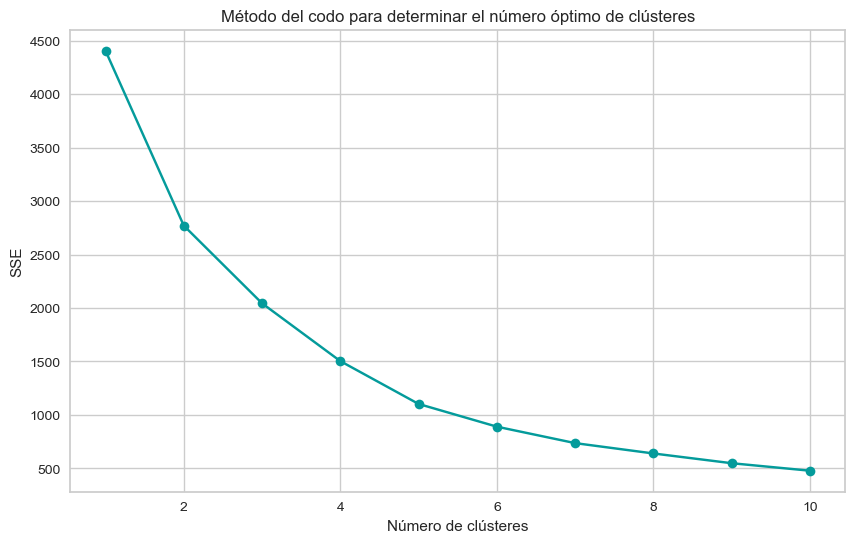



Número óptimo de clústeres: 4


In [30]:
## DETERMINACIÓN Y OPTIMIZACIÓN DE CLUSTERES

# Definimos una función para encontrar el punto de inflexión óptimo para la clausterización
def find_elbow(sse):
    diffs = np.diff(sse)
    second_diffs = np.diff(diffs)
    return np.argmin(second_diffs) - 2


# Determinamos el número óptimo de clústeres usando el método del codo
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(df_cluster_scaled)
    sse.append(kmeans.inertia_)

# Graficamos el método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', color='#049b9b')
plt.xlabel('Número de clústeres')
plt.ylabel('SSE')
plt.title('Método del codo para determinar el número óptimo de clústeres')
plt.show()

# Agregamos una separación
print("\n" + "="*50 + "\n")

# Elegimos el número de clústeres basado en el método del codo
k_optimo = find_elbow(sse)
print(f"Número óptimo de clústeres: {k_optimo}")



##### **5.1.3 Determinación  <ins>óptimo de clusteres</ins>**

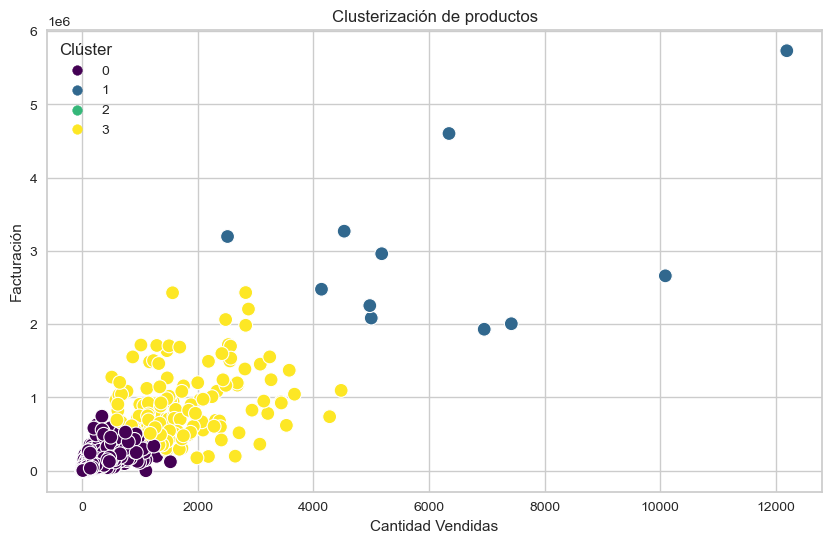

   Clúster  Productos  Ventas
0        0       1321  256190
1        1         11   69338
2        2          3       8
3        3        134  239216


In [31]:
## CLUSTERIZACIÓN

# Aplicamos k-means con el número óptimo de clústeres
kmeans = KMeans(n_clusters=k_optimo, random_state=123)
clusters = kmeans.fit_predict(df_cluster_scaled)

# Añadimos la etiqueta del clúster al DataFrame original
ventas_producto['Cluster'] = clusters

# Visualizamos los clústeres
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ventas_producto, x='Cant_vendidas', y='Facturacion', hue='Cluster', palette='viridis', s=100)
plt.title('Clusterización de productos')
plt.xlabel('Cantidad Vendidas')
plt.ylabel('Facturación')
plt.legend(title='Clúster')
plt.show()

# Calculamos la distribución de productos por clúster
cluster_distribution = ventas_producto['Cluster'].value_counts().sort_index()

# Calculamos la cantidad total de ventas por clúster
ventas_por_cluster = ventas_producto.groupby('Cluster')['Cant_vendidas'].sum().sort_index()

# Creamos un DataFrame resumen
resumen_clusters = pd.DataFrame({
    'Productos': cluster_distribution,
    'Ventas': ventas_por_cluster,
}).reset_index()

# Renombramos la columna de clúster para mayor claridad
resumen_clusters.rename(columns={'index': 'Clúster'}, inplace=True)

# Mostramos el DataFrame resumen
print(resumen_clusters)

Imágenes de los clústeres guardadas en el directorio 'cluster_images'


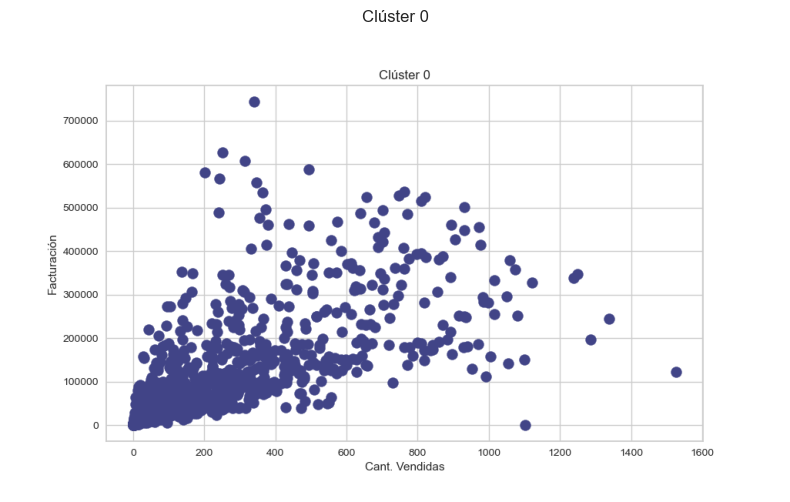

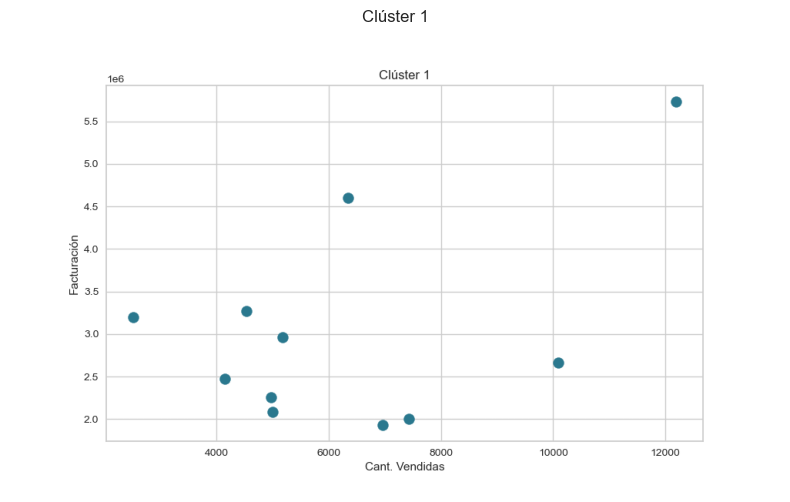

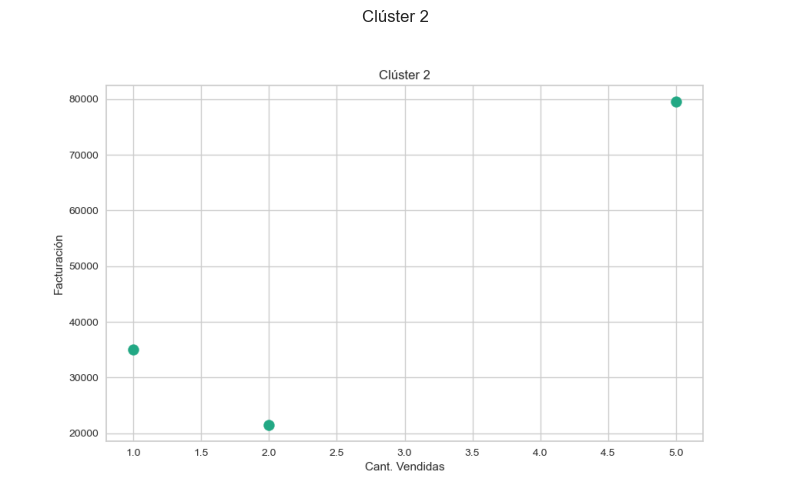

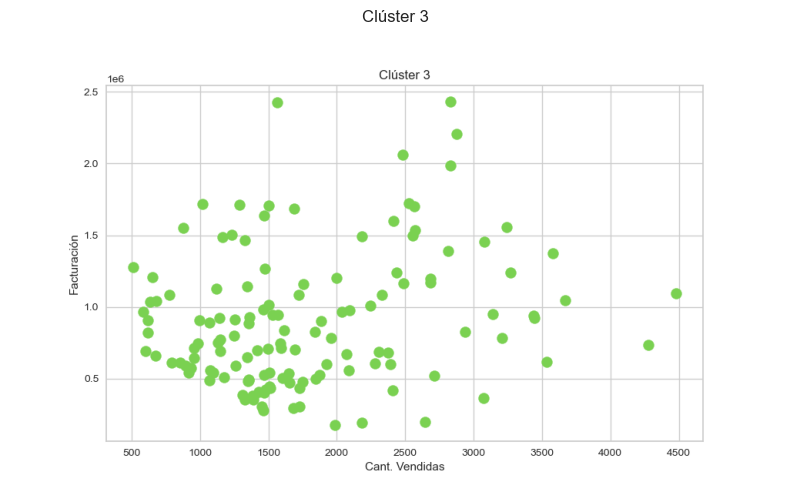

In [32]:
## CLUSTERIZACIÓN INDIVIDUAL

# Creamos un directorio para guardar las imágenes de los clústeres
output_dir = 'cluster_images'
os.makedirs(output_dir, exist_ok=True)

# Definimos colores para los clústeres utilizando la misma paleta
colors = sns.color_palette('viridis', k_optimo)

# Graficamos cada clúster por separado y guardamos cada gráfico como una imagen
for i in range(k_optimo):
    cluster_data = ventas_producto[ventas_producto['Cluster'] == i]
    plt.figure(figsize=(10, 6))
    plt.scatter(cluster_data['Cant_vendidas'], cluster_data['Facturacion'], color=colors[i], s=100)
    plt.title(f'Clúster {i}')
    plt.xlabel('Cant. Vendidas')
    plt.ylabel('Facturación')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f'cluster_{i}.png'))
    plt.close()

print(f"Imágenes de los clústeres guardadas en el directorio '{output_dir}'")

# Mostramos las imágenes generadas
for i in range(k_optimo):
    img_path = os.path.join(output_dir, f'cluster_{i}.png')
    img = plt.imread(img_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Clúster {i}')
    plt.show()

---

# **6. <ins>Simulación del modelo</ins>**



##### **6.1.1 <ins>Creación de variables</ins>: "Lag_1", "Rolling_Mean_7", "Rolling_Std_7", "Dia_del_Mes"**

In [33]:
# Creamos variable Lag_1 (ventas del día anterior)
df_merged['Lag_1'] = df_merged.groupby('ID_producto')['Cant_vendidas'].shift(1)

# Creamos variable Rolling_Mean_7 (media móvil de 7 días)
df_merged['Rolling_Mean_7'] = df_merged.groupby('ID_producto')['Cant_vendidas'].rolling(window=7).mean().reset_index(level=0, drop=True)

# Creamos variable Rolling_Std_7 (desviación estándar móvil de 7 días)
df_merged['Rolling_Std_7'] = df_merged.groupby('ID_producto')['Cant_vendidas'].rolling(window=7).std().reset_index(level=0, drop=True)

# Creamos variable Dia_del_Mes
df_merged['Dia_del_Mes'] = df_merged['Fecha_venta'].dt.day

# Eliminamos filas con valores nulos que puedan haber sido creados al generar las nuevas variables
df_merged.dropna(subset=['Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7'], inplace=True)

# Añadimos la etiqueta del clúster al DataFrame
df_merged = df_merged.merge(ventas_producto[['ID_producto', 'Cluster']], on='ID_producto', how='left')

# Verificamos el dataframe resultante
df_merged.head()

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion,Año,Mes,Lag_1,Rolling_Mean_7,Rolling_Std_7,Dia_del_Mes,Cluster
0,5201,2021-05-08,561818,6,1488.0,248.0,Sábado,1,65987,216,1,No,2021,5,10.0,4.857143,3.023716,8,3
1,5201,2021-05-08,562189,4,1076.0,269.0,Sábado,1,10214,216,1,No,2021,5,5.0,3.714286,1.799471,8,3
2,5201,2021-05-08,560779,36,9684.0,269.0,Sábado,1,10214,216,1,No,2021,5,9.0,13.714286,10.387722,8,1
3,5201,2021-05-08,560576,6,1614.0,269.0,Sábado,1,10214,216,1,No,2021,5,3.0,2.571429,1.718249,8,3
4,5201,2021-05-08,604216,2,458.0,229.0,Sábado,1,10214,216,1,No,2021,5,3.0,2.142857,0.690066,8,0




##### **6.1.2 <ins>Último precio de Venta</ins>**

In [34]:
## ÚLTIMO PRECIO DE VENTA



## Productos NO EN PROMOCIÓN

# Filtramos las ventas con promoción "No"
df_no_promo = df_merged[df_merged['Promocion'] == "No"]

# Obtenemos la última fecha de venta para cada producto sin promoción
last_date_no_promo = df_no_promo.groupby('ID_producto')['Fecha_venta'].max().reset_index()
last_date_no_promo.columns = ['ID_producto', 'Last_Date_No_Promo']

# Unimos con el DataFrame original para obtener el precio en la última fecha sin promoción
df_merged_no_promo = df_merged.merge(last_date_no_promo, on=['ID_producto'], how='left')
df_merged_no_promo = df_merged_no_promo[df_merged_no_promo['Fecha_venta'] == df_merged_no_promo['Last_Date_No_Promo']]

# Filtramos solo las columnas necesarias
df_result_no_promo = df_merged_no_promo[['ID_producto', 'Fecha_venta', 'Promocion', 'Precio_unidad']]



## Productos EN PROMOCIÓN

# Filtramos las ventas con promoción "Si"
df_si_promo = df_merged[df_merged['Promocion'] == "Si"]

# Obtenemos la última fecha de venta para cada producto con promoción
last_date_si_promo = df_si_promo.groupby('ID_producto')['Fecha_venta'].max().reset_index()
last_date_si_promo.columns = ['ID_producto', 'Last_Date_Si_Promo']

# Unimos con el DataFrame original para obtener el precio en la última fecha con promoción
df_merged_si_promo = df_merged.merge(last_date_si_promo, on=['ID_producto'], how='left')
df_merged_si_promo = df_merged_si_promo[df_merged_si_promo['Fecha_venta'] == df_merged_si_promo['Last_Date_Si_Promo']]

# Filtramos solo las columnas necesarias
df_result_si_promo = df_merged_si_promo[['ID_producto', 'Fecha_venta', 'Promocion', 'Precio_unidad']]



## UNIÓN AMBOS DATAFRAMES

# Unir los resultados de promociones "No" y "Si"
df_result = pd.concat([df_result_no_promo, df_result_si_promo]).drop_duplicates().reset_index(drop=True)

# Mostrar el dataframe resultante (opcional)
df_result.head()

,ID_producto,Fecha_venta,Promocion,Precio_unidad
0,562590,2021-08-11,No,1145.0
1,562483,2021-12-13,No,1340.0
2,562150,2022-01-15,No,395.0
3,562675,2022-06-03,No,715.0
4,562210,2022-09-24,No,1089.0


In [39]:
'''
## DESCARGA DE DATAFRAMES


# Directorio de descargas del escritorio (ajusta según tu sistema operativo y configuración)
desktop_download_path = os.path.join(os.path.expanduser("~"), "Downloads")

# Asegúrate de que el directorio de descargas existe
if not os.path.exists(desktop_download_path):
    os.makedirs(desktop_download_path)

# Directorio de Google Drive (ajusta según tu estructura de directorios)
drive_path = '/content/drive/My Drive/UMPE/15. Datathon'

# Guardar los DataFrames en el directorio de descargas del escritorio
df_result.to_csv(os.path.join(desktop_download_path, 'Prediccion_precios.csv'), index=False)
df_merged.to_csv(os.path.join(desktop_download_path, 'Dataframe_final.csv'), index=False)

# Guardar los DataFrames en Google Drive
#df_result.to_csv(os.path.join(drive_path, 'Prediccion_precios.csv'), index=False)
#df_merged.to_csv(os.path.join(drive_path, 'Dataframe_final.csv'), index=False)

print(f"Archivos guardados en el directorio de descargas del escritorio: {desktop_download_path}")
print(f"Archivos guardados en Google Drive: {drive_path}")

'''

Archivos guardados en el directorio de descargas del escritorio: /home/nico/Downloads
Archivos guardados en Google Drive: /content/drive/My Drive/UMPE/15. Datathon


In [40]:
# Directorio actual donde se está ejecutando el script
current_directory = os.getcwd()

# Guardar los DataFrames en el directorio actual
df_result.to_csv(os.path.join(current_directory, 'df_merged__prices.csv'), index=False)
df_merged.to_csv(os.path.join(current_directory, 'df_merged_original.csv'), index=False)

print(f"Archivos guardados en el directorio actual: {current_directory}")


Archivos guardados en el directorio actual: /mnt/c6c29b92-c396-4913-b7c7-b2456280d17a/Software y Programación/Ciencia de Datos/Datathon/Versiones Finales
